In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import os
import geopandas as gpd


Mounted at /content/drive


In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Data dictionary from original CSV

In [ ]:
# Data extracted and structured from the PDF file
data_dict_from_original_csvs = [
    {'Nome do Campo': 'Nº da Notificação', 'Campo (Banco Genérico)': 'nu_notificacao', 'Tipo (Tamanho)': 'varchar2(7)', 'Categoria': None, 'Descrição': 'Número da Notificação', 'Características': 'Campo chave para identificação do registro no sistema;', 'DBF': 'NU_NOTIFIC'},
    {'Nome do Campo': '1. Tipo de Notificação', 'Campo (Banco Genérico)': 'tp_notificacao', 'Tipo (Tamanho)': 'varchar2(1)', 'Categoria': '1- Negativa, 2- Individual, 3- Surto, 4- Agregado', 'Descrição': 'Identifica o tipo da notificação', 'Características': 'Campo Obrigatório', 'DBF': 'TP_NOT'},
    {'Nome do Campo': '2. Agravo', 'Campo (Banco Genérico)': 'co_cid', 'Tipo (Tamanho)': 'varchar2(5)', 'Categoria': 'Tabela de agravos do sistema com códigos (classificação internacional de doenças - CID 10) e nomes...', 'Descrição': 'Nome e código do agravo notificado segundo CID-10', 'Características': '- Campo chave; - Preenchendo o código, a descrição é preenchida automaticamente, e vice-versa;', 'DBF': 'ID_AGRAVO'},
    {'Nome do Campo': '3. Data da Notificação', 'Campo (Banco Genérico)': 'dt_notificacao', 'Tipo (Tamanho)': 'date', 'Categoria': '$dd/mm/aaaa$', 'Descrição': 'Data de preenchimento da ficha de notificação.', 'Características': 'Para os agravos agudos, a semana epidemiológica de notificação deverá ser calculada automaticamente;', 'DBF': 'DT_NOTIFIC'},
    {'Nome do Campo': '4. UF de Notificação', 'Campo (Banco Genérico)': 'co_uf_notificacao', 'Tipo (Tamanho)': 'varchar2(2)', 'Categoria': 'Tabela com Códigos padronizados pelo IBGE', 'Descrição': 'Unidade Federativa onde está localizada a unidade de saúde que realizou a notificação.', 'Características': '- Campo Obrigatório', 'DBF': 'SG_UF_NOT'},
    {'Nome do Campo': '5. Município de Notificação', 'Campo (Banco Genérico)': 'co_municipio_notificacao', 'Tipo (Tamanho)': 'varchar2(6)', 'Categoria': 'Tabela com Código e nome dos municípios do cadastro do IBGE', 'Descrição': 'Nome do município onde está localizada a unidade de saúde que realizou a notificação.', 'Características': 'Campo chave; Preenchendo o código, a descrição é preenchida automaticamente, e vice-versa;', 'DBF': 'ID_MUNICIP'},
    {'Nome do Campo': '6. Unidade de saúde', 'Campo (Banco Genérico)': 'co_unidade_notificacao', 'Tipo (Tamanho)': 'Number (7,0)', 'Categoria': 'Códigos e nomes da tabela do cadastro Nacional de Estabelecimento de Saúde (CNES)', 'Descrição': 'Nome completo e código da unidade de saúde que realizou o atendimento e notificação do caso', 'Características': 'Campo Obrigatório; Preenchendo o código, a descrição é preenchida automaticamente, e vice-versa;', 'DBF': 'ID_UNIDADE'},
    {'Nome do Campo': '7. Data da ocorrência da violência', 'Campo (Banco Genérico)': 'dt_ocorrencia', 'Tipo (Tamanho)': 'date', 'Categoria': 'dd/mm/aaaa', 'Descrição': 'Data da ocorrência da violência.', 'Características': '- Data menor ou igual (<=) a Data de Notificação;', 'DBF': 'DT_OCOR'},
    {'Nome do Campo': '8. Nome do Paciente', 'Campo (Banco Genérico)': 'no_paciente', 'Tipo (Tamanho)': 'varchar2 (70)', 'Categoria': None, 'Descrição': 'Nome completo do paciente (sem abreviações)', 'Características': '- Campo Obrigatório;', 'DBF': 'NM_PACIENT'},
    {'Nome do Campo': '9. Data de nascimento', 'Campo (Banco Genérico)': 'dt_nascimento', 'Tipo (Tamanho)': 'date', 'Categoria': 'dd/mm/aaaa', 'Descrição': 'Data de nascimento do paciente', 'Características': '- Obrigatório, caso a idade não seja preenchida; - Uma vez preenchido é, calculado automaticamente a idade;', 'DBF': 'DT_NASC'},
    {'Nome do Campo': '10. Idade', 'Campo (Banco Genérico)': 'nu_idade', 'Tipo (Tamanho)': 'number(4)', 'Categoria': '1- Hora, 2- Dia, 3- Mês, 4- Ano (Ex: 3009-nove meses, 4018-dezoito anos)', 'Descrição': 'Quando não há data de nascimento a idade deve ser digitada.', 'Características': 'Campo Obrigatório caso a data de nascimento não esteja preenchida; Preenchido automaticamente se Data de nascimento for preenchida;', 'DBF': 'NU_IDADE'},
    {'Nome do Campo': '11. Sexo', 'Campo (Banco Genérico)': 'tp_sexo', 'Tipo (Tamanho)': 'varchar2(1)', 'Categoria': 'M- Masculino, F-Feminino, I- Ignorado', 'Descrição': 'Sexo do paciente', 'Características': '- Campo Obrigatório; - Se Sexo Masculino, desabilitar o campo Gestante;', 'DBF': 'CS_SEXO'},
    {'Nome do Campo': '12. Gestante', 'Campo (Banco Genérico)': 'tp_gestante', 'Tipo (Tamanho)': 'varchar2(1)', 'Categoria': '1- 1º Trimestre, 2- 2º Trimestre, 3- 3º Trimestre, 4- Idade gestacional ignorada, 5- Não, 6- Não se aplica, 9- Ignorado', 'Descrição': 'Idade gestacional da paciente.', 'Características': 'Obrigatório, se sexo = F; - Se Sexo-Masculino, preenchido automaticamente com 6 Não se Aplica;', 'DBF': 'CS_GESTANT'},
    {'Nome do Campo': '13. Raça/Cor', 'Campo (Banco Genérico)': 'tp_raca_cor', 'Tipo (Tamanho)': 'varchar2(1)', 'Categoria': '1- branca, 2- preta, 3- amarela, 4- parda, 5- indigena, 9- ignorado', 'Descrição': 'Considera-se cor ou raça declarada pela pessoa.', 'Características': None, 'DBF': 'CS_RACA'},
    {'Nome do Campo': '14. Escolaridade', 'Campo (Banco Genérico)': 'tp_escolaridade', 'Tipo (Tamanho)': 'varchar2(2)', 'Categoria': '0- Analfabeto, 1- 1ª a 4ª série incompleta do EF, 2- 4ª série completa do EF, 3- 5ª à 8ª série incompleta do EF, 4- Ensino fundamental completo, 5- Ensino médio incompleto, 6- Ensino médio completo, 7- Educação superior incompleta, 8- Educação superior completa, 9- Ignorado, 10- Não se aplica', 'Descrição': 'Série e grau de instrução do paciente.', 'Características': 'Categoria 10- não se aplica é preenchida automaticamente quando caso notificado é < 6 anos de idade.', 'DBF': 'CS_ESCOLAR'},
    {'Nome do Campo': '15. Nº, Cartão SUS', 'Campo (Banco Genérico)': 'nu_cartao_sus', 'Tipo (Tamanho)': 'varchar2(15)', 'Categoria': None, 'Descrição': 'Número do cartão do Sistema Único de Saúde (SUS) do paciente', 'Características': None, 'DBF': 'ID_CNS_SUS'},
    {'Nome do Campo': '16. Nome da mãe', 'Campo (Banco Genérico)': 'no_nome_mae', 'Tipo (Tamanho)': 'varchar2(70)', 'Categoria': None, 'Descrição': 'Nome completo da mãe do paciente (sem abreviações)', 'Características': None, 'DBF': 'NM_MAE_PAC'},
    {'Nome do Campo': '17. UF de residência', 'Campo (Banco Genérico)': 'co_uf_residencia', 'Tipo (Tamanho)': 'varchar2(2)', 'Categoria': 'Tabela com Código dos estados padronizados pelo IBGE', 'Descrição': 'Sigla da Unidade Federada de residência do paciente.', 'Características': '- Obrigatório se residente no Brasil; Ao digitar sigla da UF, o campo País é preenchido automaticamente com "Brasil"', 'DBF': 'SG_UF'},
    {'Nome do Campo': '18. Município de residência', 'Campo (Banco Genérico)': 'co_municipio_residencia', 'Tipo (Tamanho)': 'varchar2(6)', 'Categoria': 'Tabela com Códigos e nomes padronizados pelo IBGE', 'Descrição': 'Código e nome do município de residência do caso notificado.', 'Características': 'Campo Obrigatório quando UF é digitada; São exibidos somente os Municípios pertencentes à UF selecionada.', 'DBF': 'ID_MN_RESI'},
    {'Nome do Campo': '29. Zona de residência', 'Campo (Banco Genérico)': 'tp_zona_residencia', 'Tipo (Tamanho)': 'varchar2(1)', 'Categoria': '1- Urbana, 2- Rural, 3- Periurbana, 9- Ignorado', 'Descrição': 'Zona de residência do paciente por ocasião da notificação', 'Características': None, 'DBF': 'ZONA'},
    {'Nome do Campo': '31. Ocupação', 'Campo (Banco Genérico)': 'id_ocupa_n', 'Tipo (Tamanho)': 'VARCHAR2(6)', 'Categoria': None, 'Descrição': 'Informar a atividade exercida pelo paciente.', 'Características': 'Campo Essencial', 'DBF': 'ID_OCUPA_N'},
    {'Nome do Campo': '32. Situação conjugal', 'Campo (Banco Genérico)': 'sit_conjug', 'Tipo (Tamanho)': 'varchar2(1)', 'Categoria': '1- Solteiro, 2-Casado/União consensual, 3- Viúvo, 4- Separado, 8- Não se aplica, 9- Ignorado', 'Descrição': 'Situação conjugal do paciente', 'Características': 'Categoria 8 se idade do paciente for < 10 anos', 'DBF': 'SIT_CONJUG'},
    {'Nome do Campo': '34. Possui algum tipo de deficiência/transtorno', 'Campo (Banco Genérico)': 'def_trans', 'Tipo (Tamanho)': 'varchar2(1)', 'Categoria': '1-Sim, 2-Não, 9-Ignorado', 'Descrição': 'Se o paciente possui algum tipo de deficiência/transtorno', 'Características': 'Campo Essencial. Se categoria = 2 ou 9, pular para o campo UF de ocorrência', 'DBF': 'DEF_TRANS'},
    {'Nome do Campo': '48. Local de ocorrência', 'Campo (Banco Genérico)': 'local_ocor', 'Tipo (Tamanho)': 'varchar2(2)', 'Categoria': '01- Residência, 02- Habitação coletiva, 03- Escola, 04- Local de prática esportiva, 05- Bar ou similar, 06- Via pública, 07- Comércio/Serviços, 08- Industrias/construção, 09- Outro, 99- Ignorado', 'Descrição': 'Informar o local de ocorrência do evento notificado', 'Características': 'Campo Essencial', 'DBF': 'LOCAL_OCOR'},
    {'Nome do Campo': '49. Ocorreu outras vezes?', 'Campo (Banco Genérico)': 'out_vezes', 'Tipo (Tamanho)': 'varchar2(1)', 'Categoria': '1-Sim, 2-Não, 9-Ignorado', 'Descrição': 'Informar se a violência é de repetição', 'Características': 'Campo Essencial', 'DBF': 'OUT_VEZES'},
    {'Nome do Campo': '50. A lesão foi autoprovocada?', 'Campo (Banco Genérico)': 'les_autop', 'Tipo (Tamanho)': 'varchar2(1)', 'Categoria': '1-Sim, 2-Não, 8-Não se aplica, 9-Ignorado', 'Descrição': 'Informar se a lesão foi autoprovocada', 'Características': 'Campo Essencial. Categoria 8 se idade do paciente for < 5 anos', 'DBF': 'LES_AUTOP'},
    {'Nome do Campo': '51. Violência física', 'Campo (Banco Genérico)': 'viol_fisica', 'Tipo (Tamanho)': 'varchar2(1)', 'Categoria': '1-Sim, 2-Não, 9-Ignorado', 'Descrição': 'Informar se ocorreu violência física', 'Características': 'Campo Essencial', 'DBF': 'VIOL_FISICA'},
    {'Nome do Campo': '51. Violência psicológica/moral', 'Campo (Banco Genérico)': 'viol_psico', 'Tipo (Tamanho)': 'varchar2(1)', 'Categoria': '1-Sim, 2-Não, 9-Ignorado', 'Descrição': 'Informar se ocorreu violência psicológica/moral', 'Características': 'Campo Essencial', 'DBF': 'VIOL_PSICO'},
    {'Nome do Campo': '51. Tortura', 'Campo (Banco Genérico)': 'viol_tort', 'Tipo (Tamanho)': 'varchar2(1)', 'Categoria': '1-Sim, 2-Não, 9-Ignorado', 'Descrição': 'Informar se ocorreu tortura', 'Características': 'Campo Essencial', 'DBF': 'VIOL_TORT'},
    {'Nome do Campo': '51. Violência Sexual', 'Campo (Banco Genérico)': 'viol_sexual', 'Tipo (Tamanho)': 'varchar2(1)', 'Categoria': '1-Sim, 2-Não, 9-Ignorado', 'Descrição': 'Informar se ocorreu violência sexual', 'Características': 'Campo Essencial', 'DBF': 'VIOL_SEXUAL'},
    {'Nome do Campo': '60. Relação com a pessoa atendida - Pai', 'Campo (Banco Genérico)': 'rel_pai', 'Tipo (Tamanho)': 'varchar2(1)', 'Categoria': '1-Sim, 2-Não, 9-Ignorado', 'Descrição': 'Informar se o provável autor da agressão era o pai', 'Características': None, 'DBF': 'REL_PAI'},
    {'Nome do Campo': '60. Relação com a pessoa atendida - Mãe', 'Campo (Banco Genérico)': 'rel_mae', 'Tipo (Tamanho)': 'varchar2(1)', 'Categoria': '1-Sim, 2-Não, 9-Ignorado', 'Descrição': 'Informar se o provável autor da agressão era a mãe', 'Características': 'Campo Essencial', 'DBF': 'REL_MAE'},
    {'Nome do Campo': '61. Sexo do provável autor da agressão', 'Campo (Banco Genérico)': 'autor_sexo', 'Tipo (Tamanho)': 'varchar2(1)', 'Categoria': '1- Masculino, 2- Feminino, 3- Ambos os sexos, 9- ignorado', 'Descrição': 'Informar o sexo do provável autor da agressão', 'Características': 'Campo Essencial', 'DBF': 'AUTOR_SEXO'},
    {'Nome do Campo': '62. Suspeita de uso de álcool', 'Campo (Banco Genérico)': 'autor_alcool', 'Tipo (Tamanho)': 'varchar2(1)', 'Categoria': '1-Sim, 2-Não, 9-Ignorado', 'Descrição': 'Informar se o provável autor da agressão tinha suspeita de uso de álcool', 'Características': None, 'DBF': 'AUTOR_ALCOOL'},
    {'Nome do Campo': '65. Violência relacionada ao trabalho', 'Campo (Banco Genérico)': 'rel_trab', 'Tipo (Tamanho)': 'varchar2(1)', 'Categoria': '1-Sim, 2-Não, 9-Ignorado', 'Descrição': 'Informar se ocorreu violência relacionada ao trabalho', 'Características': 'Campo Essencial', 'DBF': 'REL_TRAB'},
    {'Nome do Campo': '68. Classificação final', 'Campo (Banco Genérico)': 'clas_final', 'Tipo (Tamanho)': 'varchar2(1)', 'Categoria': '1- Confirmado, 2- Descartado, 3- Provável, 8- Inconclusivo', 'Descrição': None, 'Características': 'Campo obrigatório', 'DBF': 'CLAS_FINAL'},
    {'Nome do Campo': '69. Evolução do caso', 'Campo (Banco Genérico)': 'evolucao', 'Tipo (Tamanho)': 'varchar2(1)', 'Categoria': '1- Alta, 2- Evasão/fuga, 3- Óbito por violência, 4- Óbito por outras causas, 9-Ignorado', 'Descrição': None, 'Características': 'Campo Essencial', 'DBF': 'EVOLUCAO'},
    {'Nome do Campo': '71. Data de encerramento', 'Campo (Banco Genérico)': 'dt_encer', 'Tipo (Tamanho)': 'date', 'Categoria': 'Dd/mm/aaaa', 'Descrição': 'data de encerramento do caso.', 'Características': 'Campo data da notificação', 'DBF': 'DT_ENCER'}
]

# Create a pandas DataFrame from the list of dictionaries
df_sinan = pd.DataFrame(data_dict_from_original_csvs)

# Set the 'Nome do Campo' as the index for better readability
df_sinan.set_index('Nome do Campo', inplace=True)

# Display the DataFrame
# print(df_sinan)


# Dictionary containing data on municipalities and their codes

In [ ]:
# Data extracted from IBGE site -> https://www.ibge.gov.br/explica/codigos-dos-municipios.php
dados_municipios_es = {
    'Município': [
        'Afonso Cláudio', 'Água Doce do Norte', 'Águia Branca', 'Alegre', 'Alfredo Chaves',
        'Alto Rio Novo', 'Anchieta', 'Apiacá', 'Aracruz', 'Atílio Vivácqua', 'Baixo Guandu',
        'Barra de São Francisco', 'Boa Esperança', 'Bom Jesus do Norte', 'Brejetuba',
        'Cachoeiro de Itapemirim', 'Cariacica', 'Castelo', 'Colatina', 'Conceição da Barra',
        'Conceição do Castelo', 'Divino de São Lourenço', 'Domingos Martins', 'Dores do Rio Preto',
        'Ecoporanga', 'Fundão', 'Governador Lindenberg', 'Guaçuí', 'Guarapari', 'Ibatiba',
        'Ibiraçu', 'Ibitirama', 'Iconha', 'Irupi', 'Itaguaçu', 'Itapemirim', 'Itarana', 'Iúna',
        'Jaguaré', 'Jerônimo Monteiro', 'João Neiva', 'Laranja da Terra', 'Linhares', 'Mantenópolis',
        'Marataízes', 'Marechal Floriano', 'Marilândia', 'Mimoso do Sul', 'Montanha', 'Mucurici',
        'Muniz Freire', 'Muqui', 'Nova Venécia', 'Pancas', 'Pedro Canário', 'Pinheiros', 'Piúma',
        'Ponto Belo', 'Presidente Kennedy', 'Rio Bananal', 'Rio Novo do Sul', 'Santa Leopoldina',
        'Santa Maria de Jetibá', 'Santa Teresa', 'São Domingos do Norte', 'São Gabriel da Palha',
        'São José do Calçado', 'São Mateus', 'São Roque do Canaã', 'Serra', 'Sooretama', 'Vargem Alta',
        'Venda Nova do Imigrante', 'Viana', 'Vila Pavão', 'Vila Valério', 'Vila Velha', 'Vitória'
    ],
    'Código': [
        3200102, 3200169, 3200136, 3200201, 3200300, 3200359, 3200409, 3200508, 3200607,
        3200706, 3200805, 3200904, 3201001, 3201100, 3201159, 3201209, 3201308, 3201407,
        3201506, 3201605, 3201704, 3201803, 3201902, 3202009, 3202108, 3202207, 3202256,
        3202306, 3202405, 3202454, 3202504, 3202553, 3202603, 3202652, 3202702, 3202801,
        3202900, 3203007, 3203056, 3203106, 3203130, 3203163, 3203205, 3203304, 3203320,
        3203346, 3203353, 3203403, 3203502, 3203601, 3203700, 3203809, 3203908, 3204005,
        3204054, 3204104, 3204203, 3204252, 3204302, 3204351, 3204401, 3204500, 3204559,
        3204609, 3204658, 3204708, 3204807, 3204906, 3204955, 3205002, 3205010, 3205036,
        3205069, 3205101, 3205150, 3205176, 3205200, 3205309
    ]
}

# Creating DataFrame from Dictionary
df_es = pd.DataFrame(dados_municipios_es)

# Displaying the first few rows of the DataFrame
# print(df_es.head())


In [ ]:

# Data extracted from IBGE site -> https://www.ibge.gov.br/explica/codigos-dos-municipios.php
dados_raw_mg = """
Abadia dos Dourados 3100104
Abaeté 3100203
Abre Campo 3100302
Acaiaca 3100401
Açucena 3100500
Água Boa 3100609
Água Comprida 3100708
Aguanil 3100807
Águas Formosas 3100906
Águas Vermelhas 3101003
Aimorés 3101102
Aiuruoca 3101201
Alagoa 3101300
Albertina 3101409
Além Paraíba 3101508
Alfenas 3101607
Alfredo Vasconcelos 3101631
Almenara 3101706
Alpercata 3101805
Alpinópolis 3101904
Alterosa 3102001
Alto Caparaó 3102050
Alto Jequitibá 3153509
Alto Rio Doce 3102100
Alvarenga 3102209
Alvinópolis 3102308
Alvorada de Minas 3102407
Amparo do Serra 3102506
Andradas 3102605
Andrelândia 3102803
Angelândia 3102852
Antônio Carlos 3102902
Antônio Dias 3103009
Antônio Prado de Minas 3103108
Araçaí 3103207
Aracitaba 3103306
Araçuaí 3103405
Araguari 3103504
Arantina 3103603
Araponga 3103702
Araporã 3103751
Arapuá 3103801
Araújos 3103900
Araxá 3104007
Arceburgo 3104106
Arcos 3104205
Areado 3104304
Argirita 3104403
Aricanduva 3104452
Arinos 3104502
Astolfo Dutra 3104601
Ataléia 3104700
Augusto de Lima 3104809
Baependi 3104908
Baldim 3105004
Bambuí 3105103
Bandeira 3105202
Bandeira do Sul 3105301
Barão de Cocais 3105400
Barão do Monte Alto 3105509
Barbacena 3105608
Barra Longa 3105707
Barroso 3105905
Bela Vista de Minas 3106002
Belmiro Braga 3106101
Belo Horizonte 3106200
Belo Oriente 3106309
Belo Vale 3106408
Berilo 3106507
Berizal 3106655
Bertópolis 3106606
Betim 3106705
Bias Fortes 3106804
Bicas 3106903
Biquinhas 3107000
Boa Esperança 3107109
Bocaina de Minas 3107208
Bocaiúva 3107307
Bom Despacho 3107406
Bom Jardim de Minas 3107505
Bom Jesus da Penha 3107604
Bom Jesus do Amparo 3107703
Bom Jesus do Galho 3107802
Bom Repouso 3107901
Bom Sucesso 3108008
Bonfim 3108107
Bonfinópolis de Minas 3108206
Bonito de Minas 3108255
Borda da Mata 3108305
Botelhos 3108404
Botumirim 3108503
Brás Pires 3108701
Brasilândia de Minas 3108552
Brasília de Minas 3108602
Braúnas 3108800
Brazópolis 3108909
Brumadinho 3109006
Bueno Brandão 3109105
Buenópolis 3109204
Bugre 3109253
Buritis 3109303
Buritizeiro 3109402
Cabeceira Grande 3109451
Cabo Verde 3109501
Cachoeira Dourada 3109808
Cachoeira da Prata 3109600
Cachoeira de Minas 3109709
Cachoeira de Pajeú 3102704
Caetanópolis 3109907
Caeté 3110004
Caiana 3110103
Cajuri 3110202
Caldas 3110301
Camacho 3110400
Camanducaia 3110509
Cambuí 3110608
Cambuquira 3110707
Campanário 3110806
Campanha 3110905
Campestre 3111002
Campina Verde 3111101
Campo Azul 3111150
Campo Belo 3111200
Campo Florido 3111408
Campo do Meio 3111309
Campos Altos 3111507
Campos Gerais 3111606
Cana Verde 3111903
Canaã 3111705
Canápolis 3111804
Candeias 3112000
Cantagalo 3112059
Caparaó 3112109
Capela Nova 3112208
Capelinha 3112307
Capetinga 3112406
Capim Branco 3112505
Capinópolis 3112604
Capitão Andrade 3112653
Capitão Enéas 3112703
Capitólio 3112802
Caputira 3112901
Caraí 3113008
Caranaíba 3113107
Carandaí 3113206
Carangola 3113305
Caratinga 3113404
Carbonita 3113503
Careaçu 3113602
Carlos Chagas 3113701
Carmésia 3113800
Carmo da Cachoeira 3113909
Carmo da Mata 3114006
Carmo de Minas 3114105
Carmo do Cajuru 3114204
Carmo do Paranaíba 3114303
Carmo do Rio Claro 3114402
Carmópolis de Minas 3114501
Carneirinho 3114550
Carrancas 3114600
Carvalhópolis 3114709
Carvalhos 3114808
Casa Grande 3114907
Cascalho Rico 3115003
Cássia 3115102
Cataguases 3115300
Catas Altas 3115359
Catas Altas da Noruega 3115409
Catuji 3115458
Catuti 3115474
Caxambu 3115508
Cedro do Abaeté 3115607
Central de Minas 3115706
Centralina 3115805
Chácara 3115904
Chalé 3116001
Chapada Gaúcha 3116159
Chapada do Norte 3116100
Chiador 3116209
Cipotânea 3116308
Claraval 3116407
Claro dos Poções 3116506
Cláudio 3116605
Coimbra 3116704
Coluna 3116803
Comendador Gomes 3116902
Comercinho 3117009
Conceição da Aparecida 3117108
Conceição da Barra de Minas 3115201
Conceição das Alagoas 3117306
Conceição das Pedras 3117207
Conceição de Ipanema 3117405
Conceição do Mato Dentro 3117504
Conceição do Pará 3117603
Conceição do Rio Verde 3117702
Conceição dos Ouros 3117801
Cônego Marinho 3117836
Confins 3117876
Congonhal 3117900
Congonhas 3118007
Congonhas do Norte 3118106
Conquista 3118205
Conselheiro Lafaiete 3118304
Conselheiro Pena 3118403
Consolação 3118502
Contagem 3118601
Coqueiral 3118700
Coração de Jesus 3118809
Cordisburgo 3118908
Cordislândia 3119005
Corinto 3119104
Coroaci 3119203
Coromandel 3119302
Coronel Fabriciano 3119401
Coronel Murta 3119500
Coronel Pacheco 3119609
Coronel Xavier Chaves 3119708
Córrego Danta 3119807
Córrego Fundo 3119955
Córrego Novo 3120003
Córrego do Bom Jesus 3119906
Couto de Magalhães de Minas 3120102
Crisólita 3120151
Cristais 3120201
Cristália 3120300
Cristiano Otoni 3120409
Cristina 3120508
Crucilândia 3120607
Cruzeiro da Fortaleza 3120706
Cruzília 3120805
Cuparaque 3120839
Curral de Dentro 3120870
Curvelo 3120904
Datas 3121001
Delfim Moreira 3121100
Delfinópolis 3121209
Delta 3121258
Descoberto 3121308
Desterro de Entre Rios 3121407
Desterro do Melo 3121506
Diamantina 3121605
Diogo de Vasconcelos 3121704
Dionísio 3121803
Divinésia 3121902
Divino 3122009
Divino das Laranjeiras 3122108
Divinolândia de Minas 3122207
Divinópolis 3122306
Divisa Alegre 3122355
Divisa Nova 3122405
Divisópolis 3122454
Dom Bosco 3122470
Dom Cavati 3122504
Dom Joaquim 3122603
Dom Silvério 3122702
Dom Viçoso 3122801
Dona Euzébia 3122900
Dores de Campos 3123007
Dores de Guanhães 3123106
Dores do Indaiá 3123205
Dores do Turvo 3123304
Doresópolis 3123403
Douradoquara 3123502
Durandé 3123528
Elói Mendes 3123601
Engenheiro Caldas 3123700
Engenheiro Navarro 3123809
Entre Folhas 3123858
Entre Rios de Minas 3123908
Ervália 3124005
Esmeraldas 3124104
Espera Feliz 3124203
Espinosa 3124302
Espírito Santo do Dourado 3124401
Estiva 3124500
Estrela Dalva 3124609
Estrela do Indaiá 3124708
Estrela do Sul 3124807
Eugenópolis 3124906
Ewbank da Câmara 3125002
Extrema 3125101
Fama 3125200
Faria Lemos 3125309
Felício dos Santos 3125408
Felisburgo 3125606
Felixlândia 3125705
Fernandes Tourinho 3125804
Ferros 3125903
Fervedouro 3125952
Florestal 3126000
Formiga 3126109
Formoso 3126208
Fortaleza de Minas 3126307
Fortuna de Minas 3126406
Francisco Badaró 3126505
Francisco Dumont 3126604
Francisco Sá 3126703
Franciscópolis 3126752
Frei Gaspar 3126802
Frei Inocêncio 3126901
Frei Lagonegro 3126950
Fronteira 3127008
Fronteira dos Vales 3127057
Fruta de Leite 3127073
Frutal 3127107
Funilândia 3127206
Galiléia 3127305
Gameleiras 3127339
Glaucilândia 3127354
Goiabeira 3127370
Goianá 3127388
Gonçalves 3127404
Gonzaga 3127503
Gouveia 3127602
Governador Valadares 3127701
Grão Mogol 3127800
Grupiara 3127909
Guanhães 3128006
Guapé 3128105
Guaraciaba 3128204
Guaraciama 3128253
Guaranésia 3128303
Guarani 3128402
Guarará 3128501
Guarda-Mor 3128600
Guaxupé 3128709
Guidoval 3128808
Guimarânia 3128907
Guiricema 3129004
Gurinhatã 3129103
Heliodora 3129202
Iapu 3129301
Ibertioga 3129400
Ibiá 3129509
Ibiaí 3129608
Ibiracatu 3129657
Ibiraci 3129707
Ibirité 3129806
Ibitiúra de Minas 3129905
Ibituruna 3130002
Icaraí de Minas 3130051
Igarapé 3130101
Igaratinga 3130200
Iguatama 3130309
Ijaci 3130408
Ilicínea 3130507
Imbé de Minas 3130556
Inconfidentes 3130606
Indaiabira 3130655
Indianópolis 3130705
Ingaí 3130804
Inhapim 3130903
Inhaúma 3131000
Inimutaba 3131109
Ipaba 3131158
Ipanema 3131208
Ipatinga 3131307
Ipiaçu 3131406
Ipuiúna 3131505
Iraí de Minas 3131604
Itabira 3131703
Itabirinha 3131802
Itabirito 3131901
Itacambira 3132008
Itacarambi 3132107
Itaguara 3132206
Itaipé 3132305
Itajubá 3132404
Itamarandiba 3132503
Itamarati de Minas 3132602
Itambacuri 3132701
Itambé do Mato Dentro 3132800
Itamogi 3132909
Itamonte 3133006
Itanhandu 3133105
Itanhomi 3133204
Itaobim 3133303
Itapagipe 3133402
Itapecerica 3133501
Itapeva 3133600
Itatiaiuçu 3133709
Itaú de Minas 3133758
Itaúna 3133808
Itaverava 3133907
Itinga 3134004
Itueta 3134103
Ituiutaba 3134202
Itumirim 3134301
Iturama 3134400
Itutinga 3134509
Jaboticatubas 3134608
Jacinto 3134707
Jacuí 3134806
Jacutinga 3134905
Jaguaraçu 3135001
Jaíba 3135050
Jampruca 3135076
Janaúba 3135100
Januária 3135209
Japaraíba 3135308
Japonvar 3135357
Jeceaba 3135407
Jenipapo de Minas 3135456
Jequeri 3135506
Jequitaí 3135605
Jequitibá 3135704
Jequitinhonha 3135803
Jesuânia 3135902
Joaíma 3136009
Joanésia 3136108
João Monlevade 3136207
João Pinheiro 3136306
Joaquim Felício 3136405
Jordânia 3136504
José Gonçalves de Minas 3136520
José Raydan 3136553
Josenópolis 3136579
Juatuba 3136652
Juiz de Fora 3136702
Juramento 3136801
Juruaia 3136900
Juvenília 3136959
Ladainha 3137007
Lagamar 3137106
Lagoa Dourada 3137403
Lagoa Formosa 3137502
Lagoa Grande 3137536
Lagoa Santa 3137601
Lagoa da Prata 3137205
Lagoa dos Patos 3137304
Lajinha 3137700
Lambari 3137809
Lamim 3137908
Laranjal 3138005
Lassance 3138104
Lavras 3138203
Leandro Ferreira 3138302
Leme do Prado 3138351
Leopoldina 3138401
Liberdade 3138500
Lima Duarte 3138609
Limeira do Oeste 3138625
Lontra 3138658
Luisburgo 3138674
Luislândia 3138682
Luminárias 3138708
Luz 3138807
Machacalis 3138906
Machado 3139003
Madre de Deus de Minas 3139102
Malacacheta 3139201
Mamonas 3139250
Manga 3139300
Manhuaçu 3139409
Manhumirim 3139508
Mantena 3139607
Mar de Espanha 3139805
Maravilhas 3139706
Maria da Fé 3139904
Mariana 3140001
Marilac 3140100
Mário Campos 3140159
Maripá de Minas 3140209
Marliéria 3140308
Marmelópolis 3140407
Martinho Campos 3140506
Martins Soares 3140530
Mata Verde 3140555
Materlândia 3140605
Mateus Leme 3140704
Mathias Lobato 3171501
Matias Barbosa 3140803
Matias Cardoso 3140852
Matipó 3140902
Mato Verde 3141009
Matozinhos 3141108
Matutina 3141207
Medeiros 3141306
Medina 3141405
Mendes Pimentel 3141504
Mercês 3141603
Mesquita 3141702
Minas Novas 3141801
Minduri 3141900
Mirabela 3142007
Miradouro 3142106
Miraí 3142205
Miravânia 3142254
Moeda 3142304
Moema 3142403
Monjolos 3142502
Monsenhor Paulo 3142601
Montalvânia 3142700
Monte Alegre de Minas 3142809
Monte Azul 3142908
Monte Belo 3143005
Monte Carmelo 3143104
Monte Formoso 3143153
Monte Santo de Minas 3143203
Monte Sião 3143401
Montes Claros 3143302
Montezuma 3143450
Morada Nova de Minas 3143500
Morro da Garça 3143609
Morro do Pilar 3143708
Munhoz 3143807
Muriaé 3143906
Mutum 3144003
Muzambinho 3144102
Nacip Raydan 3144201
Nanuque 3144300
Naque 3144359
Natalândia 3144375
Natércia 3144409
Nazareno 3144508
Nepomuceno 3144607
Ninheira 3144656
Nova Belém 3144672
Nova Era 3144706
Nova Lima 3144805
Nova Módica 3144904
Nova Ponte 3145000
Nova Porteirinha 3145059
Nova Resende 3145109
Nova Serrana 3145208
Nova União 3136603
Novo Cruzeiro 3145307
Novo Oriente de Minas 3145356
Novorizonte 3145372
Olaria 3145406
Olhos-d'Água 3145455
Olímpio Noronha 3145505
Oliveira 3145604
Oliveira Fortes 3145703
Onça de Pitangui 3145802
Oratórios 3145851
Orizânia 3145877
Ouro Branco 3145901
Ouro Fino 3146008
Ouro Preto 3146107
Ouro Verde de Minas 3146206
Padre Carvalho 3146255
Padre Paraíso 3146305
Pai Pedro 3146552
Paineiras 3146404
Pains 3146503
Paiva 3146602
Palma 3146701
Palmópolis 3146750
Papagaios 3146909
Pará de Minas 3147105
Paracatu 3147006
Paraguaçu 3147204
Paraisópolis 3147303
Paraopeba 3147402
Passa Quatro 3147600
Passa Tempo 3147709
Passa Vinte 3147808
Passabém 3147501
Passos 3147907
Patis 3147956
Patos de Minas 3148004
Patrocínio 3148103
Patrocínio do Muriaé 3148202
Paula Cândido 3148301
Paulistas 3148400
Pavão 3148509
Peçanha 3148608
Pedra Azul 3148707
Pedra Bonita 3148756
Pedra Dourada 3149002
Pedra do Anta 3148806
Pedra do Indaiá 3148905
Pedralva 3149101
Pedras de Maria da Cruz 3149150
Pedrinópolis 3149200
Pedro Leopoldo 3149309
Pedro Teixeira 3149408
Pequeri 3149507
Pequi 3149606
Perdigão 3149705
Perdizes 3149804
Perdões 3149903
Periquito 3149952
Pescador 3150000
Piau 3150109
Piedade de Caratinga 3150158
Piedade de Ponte Nova 3150208
Piedade do Rio Grande 3150307
Piedade dos Gerais 3150406
Pimenta 3150505
Pingo-d'Água 3150539
Pintópolis 3150570
Piracema 3150604
Pirajuba 3150703
Piranga 3150802
Piranguçu 3150901
Piranguinho 3151008
Pirapetinga 3151107
Pirapora 3151206
Piraúba 3151305
Pitangui 3151404
Piumhi 3151503
Planura 3151602
Poço Fundo 3151701
Poços de Caldas 3151800
Pocrane 3151909
Pompéu 3152006
Ponte Nova 3152105
Ponto Chique 3152131
Ponto dos Volantes 3152170
Porteirinha 3152204
Porto Firme 3152303
Poté 3152402
Pouso Alegre 3152501
Pouso Alto 3152600
Prados 3152709
Prata 3152808
Pratápolis 3152907
Pratinha 3153004
Presidente Bernardes 3153103
Presidente Juscelino 3153202
Presidente Kubitschek 3153301
Presidente Olegário 3153400
Prudente de Morais 3153608
Quartel Geral 3153707
Queluzito 3153806
Raposos 3153905
Raul Soares 3154002
Recreio 3154101
Reduto 3154150
Resende Costa 3154200
Resplendor 3154309
Ressaquinha 3154408
Riachinho 3154457
Riacho dos Machados 3154507
Ribeirão Vermelho 3154705
Ribeirão das Neves 3154606
Rio Acima 3154804
Rio Casca 3154903
Rio Doce 3155009
Rio Espera 3155207
Rio Manso 3155306
Rio Novo 3155405
Rio Paranaíba 3155504
Rio Pardo de Minas 3155603
Rio Piracicaba 3155702
Rio Pomba 3155801
Rio Preto 3155900
Rio Vermelho 3156007
Rio do Prado 3155108
Ritápolis 3156106
Rochedo de Minas 3156205
Rodeiro 3156304
Romaria 3156403
Rosário da Limeira 3156452
Rubelita 3156502
Rubim 3156601
Sabará 3156700
Sabinópolis 3156809
Sacramento 3156908
Salinas 3157005
Salto da Divisa 3157104
Santa Bárbara 3157203
Santa Bárbara do Leste 3157252
Santa Bárbara do Monte Verde 3157278
Santa Bárbara do Tugúrio 3157302
Santa Cruz de Minas 3157336
Santa Cruz de Salinas 3157377
Santa Cruz do Escalvado 3157401
Santa Efigênia de Minas 3157500
Santa Fé de Minas 3157609
Santa Helena de Minas 3157658
Santa Juliana 3157708
Santa Luzia 3157807
Santa Margarida 3157906
Santa Maria de Itabira 3158003
Santa Maria do Salto 3158102
Santa Maria do Suaçuí 3158201
Santa Rita de Caldas 3159209
Santa Rita de Ibitipoca 3159407
Santa Rita de Jacutinga 3159308
Santa Rita de Minas 3159357
Santa Rita do Itueto 3159506
Santa Rita do Sapucaí 3159605
Santa Rosa da Serra 3159704
Santa Vitória 3159803
Santana da Vargem 3158300
Santana de Cataguases 3158409
Santana de Pirapama 3158508
Santana do Deserto 3158607
Santana do Garambéu 3158706
Santana do Jacaré 3158805
Santana do Manhuaçu 3158904
Santana do Paraíso 3158953
Santana do Riacho 3159001
Santana dos Montes 3159100
Santo Antônio do Amparo 3159902
Santo Antônio do Aventureiro 3160009
Santo Antônio do Grama 3160108
Santo Antônio do Itambé 3160207
Santo Antônio do Jacinto 3160306
Santo Antônio do Monte 3160405
Santo Antônio do Retiro 3160454
Santo Antônio do Rio Abaixo 3160504
Santo Hipólito 3160603
Santos Dumont 3160702
São Bento Abade 3160801
São Brás do Suaçuí 3160900
São Domingos das Dores 3160959
São Domingos do Prata 3161007
São Félix de Minas 3161056
São Francisco 3161106
São Francisco de Paula 3161205
São Francisco de Sales 3161304
São Francisco do Glória 3161403
São Geraldo 3161502
São Geraldo da Piedade 3161601
São Geraldo do Baixio 3161650
São Gonçalo do Abaeté 3161700
São Gonçalo do Pará 3161809
São Gonçalo do Rio Abaixo 3161908
São Gonçalo do Rio Preto 3125507
São Gonçalo do Sapucaí 3162005
São Gotardo 3162104
São João Batista do Glória 3162203
São João Evangelista 3162807
São João Nepomuceno 3162906
São João da Lagoa 3162252
São João da Mata 3162302
São João da Ponte 3162401
São João das Missões 3162450
São João del Rei 3162500
São João do Manhuaçu 3162559
São João do Manteninha 3162575
São João do Oriente 3162609
São João do Pacuí 3162658
São João do Paraíso 3162708
São Joaquim de Bicas 3162922
São José da Barra 3162948
São José da Lapa 3162955
São José da Safira 3163003
São José da Varginha 3163102
São José do Alegre 3163201
São José do Divino 3163300
São José do Goiabal 3163409
São José do Jacuri 3163508
São José do Mantimento 3163607
São Lourenço 3163706
São Miguel do Anta 3163805
São Pedro da União 3163904
São Pedro do Suaçuí 3164100
São Pedro dos Ferros 3164001
São Romão 3164209
São Roque de Minas 3164308
São Sebastião da Bela Vista 3164407
São Sebastião da Vargem Alegre 3164431
São Sebastião do Anta 3164472
São Sebastião do Maranhão 3164506
São Sebastião do Oeste 3164605
São Sebastião do Paraíso 3164704
São Sebastião do Rio Preto 3164803
São Sebastião do Rio Verde 3164902
São Tiago 3165008
São Tomás de Aquino 3165107
São Tomé das Letras 3165206
São Vicente de Minas 3165305
Sapucaí-Mirim 3165404
Sardoá 3165503
Sarzedo 3165537
Sem-Peixe 3165560
Senador Amaral 3165578
Senador Cortes 3165602
Senador Firmino 3165701
Senador José Bento 3165800
Senador Modestino Gonçalves 3165909
Senhora de Oliveira 3166006
Senhora do Porto 3166105
Senhora dos Remédios 3166204
Sericita 3166303
Seritinga 3166402
Serra Azul de Minas 3166501
Serra da Saudade 3166600
Serra do Salitre 3166808
Serra dos Aimorés 3166709
Serrania 3166907
Serranópolis de Minas 3166956
Serranos 3167004
Serro 3167103
Sete Lagoas 3167202
Setubinha 3165552
Silveirânia 3167301
Silvianópolis 3167400
Simão Pereira 3167509
Simonésia 3167608
Sobrália 3167707
Soledade de Minas 3167806
Tabuleiro 3167905
Taiobeiras 3168002
Taparuba 3168051
Tapira 3168101
Tapiraí 3168200
Taquaraçu de Minas 3168309
Tarumirim 3168408
Teixeiras 3168507
Teófilo Otoni 3168606
Timóteo 3168705
Tiradentes 3168804
Tiros 3168903
Tocantins 3169000
Tocos do Moji 3169059
Toledo 3169109
Tombos 3169208
Três Corações 3169307
Três Marias 3169356
Três Pontas 3169406
Tumiritinga 3169505
Tupaciguara 3169604
Turmalina 3169703
Turvolândia 3169802
Ubá 3169901
Ubaí 3170008
Ubaporanga 3170057
Uberaba 3170107
Uberlândia 3170206
Umburatiba 3170305
Unaí 3170404
União de Minas 3170438
Uruana de Minas 3170479
Urucânia 3170503
Urucuia 3170529
Vargem Alegre 3170578
Vargem Bonita 3170602
Vargem Grande do Rio Pardo 3170651
Varginha 3170701
Varjão de Minas 3170750
Várzea da Palma 3170800
Varzelândia 3170909
Vazante 3171006
Verdelândia 3171030
Veredinha 3171071
Veríssimo 3171105
Vermelho Novo 3171154
Vespasiano 3171204
Viçosa 3171303
Vieiras 3171402
Virgem da Lapa 3171600
Virgínia 3171709
Virginópolis 3171808
Virgolândia 3171907
Visconde do Rio Branco 3172004
Volta Grande 3172103
Wenceslau Braz 3172202
"""

# Creating empty lists for municipalities and codes
municipios = []
codigos = []

# Processing each line of the data string
for linha in dados_raw_mg.strip().split('\n'):
    # The rsplit(' ', 1) function splits the string from the right, only once.
    # This ensures that county names with spaces are kept together.
    partes = linha.rsplit(' ', 1)
    if len(partes) == 2:
        municipios.append(partes[0])
        codigos.append(int(partes[1])) # Convert code to integer

# Creating the dictionary for the DataFrame
dados_mg = {
    'Município': municipios,
    'Código': codigos
}

# Creating the DataFrame
df_mg = pd.DataFrame(dados_mg)

# Displaying the DataFrame (first 5 and last 5 rows)
# print("Municípios de Minas Gerais:")
# print(df_mg)

In [ ]:

# Data extracted from IBGE site -> https://www.ibge.gov.br/explica/codigos-dos-municipios.php
dados_raw_sp = """
Adamantina 3500105
Adolfo 3500204
Aguaí 3500303
Águas da Prata 3500402
Águas de Lindóia 3500501
Águas de Santa Bárbara 3500550
Águas de São Pedro 3500600
Agudos 3500709
Alambari 3500758
Alfredo Marcondes 3500808
Altair 3500907
Altinópolis 3501004
Alto Alegre 3501103
Alumínio 3501152
Álvares Florence 3501202
Álvares Machado 3501301
Álvaro de Carvalho 3501400
Alvinlândia 3501509
Americana 3501608
Américo Brasiliense 3501707
Américo de Campos 3501806
Amparo 3501905
Analândia 3502002
Andradina 3502101
Angatuba 3502200
Anhembi 3502309
Anhumas 3502408
Aparecida 3502507
Aparecida d'Oeste 3502606
Apiaí 3502705
Araçariguama 3502754
Araçatuba 3502804
Araçoiaba da Serra 3502903
Aramina 3503000
Arandu 3503109
Arapeí 3503158
Araraquara 3503208
Araras 3503307
Arco-Íris 3503356
Arealva 3503406
Areias 3503505
Areiópolis 3503604
Ariranha 3503703
Artur Nogueira 3503802
Arujá 3503901
Aspásia 3503950
Assis 3504008
Atibaia 3504107
Auriflama 3504206
Avaí 3504305
Avanhandava 3504404
Avaré 3504503
Bady Bassitt 3504602
Balbinos 3504701
Bálsamo 3504800
Bananal 3504909
Barão de Antonina 3505005
Barbosa 3505104
Bariri 3505203
Barra Bonita 3505302
Barra do Chapéu 3505351
Barra do Turvo 3505401
Barretos 3505500
Barrinha 3505609
Barueri 3505708
Bastos 3505807
Batatais 3505906
Bauru 3506003
Bebedouro 3506102
Bento de Abreu 3506201
Bernardino de Campos 3506300
Bertioga 3506359
Bilac 3506409
Birigui 3506508
Biritiba Mirim 3506607
Boa Esperança do Sul 3506706
Bocaina 3506805
Bofete 3506904
Boituva 3507001
Bom Jesus dos Perdões 3507100
Bom Sucesso de Itararé 3507159
Borá 3507209
Boracéia 3507308
Borborema 3507407
Borebi 3507456
Botucatu 3507506
Bragança Paulista 3507605
Braúna 3507704
Brejo Alegre 3507753
Brodowski 3507803
Brotas 3507902
Buri 3508009
Buritama 3508108
Buritizal 3508207
Cabrália Paulista 3508306
Cabreúva 3508405
Caçapava 3508504
Cachoeira Paulista 3508603
Caconde 3508702
Cafelândia 3508801
Caiabu 3508900
Caieiras 3509007
Caiuá 3509106
Cajamar 3509205
Cajati 3509254
Cajobi 3509304
Cajuru 3509403
Campina do Monte Alegre 3509452
Campinas 3509502
Campo Limpo Paulista 3509601
Campos Novos Paulista 3509809
Campos do Jordão 3509700
Cananéia 3509908
Canas 3509957
Cândido Mota 3510005
Cândido Rodrigues 3510104
Canitar 3510153
Capão Bonito 3510203
Capela do Alto 3510302
Capivari 3510401
Caraguatatuba 3510500
Carapicuíba 3510609
Cardoso 3510708
Casa Branca 3510807
Cássia dos Coqueiros 3510906
Castilho 3511003
Catanduva 3511102
Catiguá 3511201
Cedral 3511300
Cerqueira César 3511409
Cerquilho 3511508
Cesário Lange 3511607
Charqueada 3511706
Chavantes 3557204
Clementina 3511904
Colina 3512001
Colômbia 3512100
Conchal 3512209
Conchas 3512308
Cordeirópolis 3512407
Coroados 3512506
Coronel Macedo 3512605
Corumbataí 3512704
Cosmópolis 3512803
Cosmorama 3512902
Cotia 3513009
Cravinhos 3513108
Cristais Paulista 3513207
Cruzália 3513306
Cruzeiro 3513405
Cubatão 3513504
Cunha 3513603
Descalvado 3513702
Diadema 3513801
Dirce Reis 3513850
Divinolândia 3513900
Dobrada 3514007
Dois Córregos 3514106
Dolcinópolis 3514205
Dourado 3514304
Dracena 3514403
Duartina 3514502
Dumont 3514601
Echaporã 3514700
Eldorado 3514809
Elias Fausto 3514908
Elisiário 3514924
Embaúba 3514957
Embu das Artes 3515004
Embu-Guaçu 3515103
Emilianópolis 3515129
Engenheiro Coelho 3515152
Espírito Santo do Pinhal 3515186
Espírito Santo do Turvo 3515194
Estiva Gerbi 3557303
Estrela d'Oeste 3515202
Estrela do Norte 3515301
Euclides da Cunha Paulista 3515350
Fartura 3515400
Fernando Prestes 3515608
Fernandópolis 3515509
Fernão 3515657
Ferraz de Vasconcelos 3515707
Flora Rica 3515806
Floreal 3515905
Flórida Paulista 3516002
Florínea 3516101
Franca 3516200
Francisco Morato 3516309
Franco da Rocha 3516408
Gabriel Monteiro 3516507
Gália 3516606
Garça 3516705
Gastão Vidigal 3516804
Gavião Peixoto 3516853
General Salgado 3516903
Getulina 3517000
Glicério 3517109
Guaiçara 3517208
Guaimbê 3517307
Guaíra 3517406
Guapiaçu 3517505
Guapiara 3517604
Guará 3517703
Guaraçaí 3517802
Guaraci 3517901
Guarani d'Oeste 3518008
Guarantã 3518107
Guararapes 3518206
Guararema 3518305
Guaratinguetá 3518404
Guareí 3518503
Guariba 3518602
Guarujá 3518701
Guarulhos 3518800
Guatapará 3518859
Guzolândia 3518909
Herculândia 3519006
Holambra 3519055
Hortolândia 3519071
Iacanga 3519105
Iacri 3519204
Iaras 3519253
Ibaté 3519303
Ibirá 3519402
Ibirarema 3519501
Ibitinga 3519600
Ibiúna 3519709
Icém 3519808
Iepê 3519907
Igaraçu do Tietê 3520004
Igarapava 3520103
Igaratá 3520202
Iguape 3520301
Ilha Comprida 3520426
Ilha Solteira 3520442
Ilhabela 3520400
Indaiatuba 3520509
Indiana 3520608
Indiaporã 3520707
Inúbia Paulista 3520806
Ipaussu 3520905
Iperó 3521002
Ipeúna 3521101
Ipiguá 3521150
Iporanga 3521200
Ipuã 3521309
Iracemápolis 3521408
Irapuã 3521507
Irapuru 3521606
Itaberá 3521705
Itaí 3521804
Itajobi 3521903
Itaju 3522000
Itanhaém 3522109
Itaoca 3522158
Itapecerica da Serra 3522208
Itapetininga 3522307
Itapeva 3522406
Itapevi 3522505
Itapira 3522604
Itapirapuã Paulista 3522653
Itápolis 3522703
Itaporanga 3522802
Itapuí 3522901
Itapura 3523008
Itaquaquecetuba 3523107
Itararé 3523206
Itariri 3523305
Itatiba 3523404
Itatinga 3523503
Itirapina 3523602
Itirapuã 3523701
Itobi 3523800
Itu 3523909
Itupeva 3524006
Ituverava 3524105
Jaborandi 3524204
Jaboticabal 3524303
Jacareí 3524402
Jaci 3524501
Jacupiranga 3524600
Jaguariúna 3524709
Jales 3524808
Jambeiro 3524907
Jandira 3525003
Jardinópolis 3525102
Jarinu 3525201
Jaú 3525300
Jeriquara 3525409
Joanópolis 3525508
João Ramalho 3525607
José Bonifácio 3525706
Júlio Mesquita 3525805
Jumirim 3525854
Jundiaí 3525904
Junqueirópolis 3526001
Juquiá 3526100
Juquitiba 3526209
Lagoinha 3526308
Laranjal Paulista 3526407
Lavínia 3526506
Lavrinhas 3526605
Leme 3526704
Lençóis Paulista 3526803
Limeira 3526902
Lindóia 3527009
Lins 3527108
Lorena 3527207
Lourdes 3527256
Louveira 3527306
Lucélia 3527405
Lucianópolis 3527504
Luís Antônio 3527603
Luiziânia 3527702
Lupércio 3527801
Lutécia 3527900
Macatuba 3528007
Macaubal 3528106
Macedônia 3528205
Magda 3528304
Mairinque 3528403
Mairiporã 3528502
Manduri 3528601
Marabá Paulista 3528700
Maracaí 3528809
Marapoama 3528858
Mariápolis 3528908
Marília 3529005
Marinópolis 3529104
Martinópolis 3529203
Matão 3529302
Mauá 3529401
Mendonça 3529500
Meridiano 3529609
Mesópolis 3529658
Miguelópolis 3529708
Mineiros do Tietê 3529807
Mira Estrela 3530003
Miracatu 3529906
Mirandópolis 3530102
Mirante do Paranapanema 3530201
Mirassol 3530300
Mirassolândia 3530409
Mococa 3530508
Mogi Guaçu 3530706
Mogi Mirim 3530805
Mogi das Cruzes 3530607
Mombuca 3530904
Monções 3531001
Mongaguá 3531100
Monte Alegre do Sul 3531209
Monte Alto 3531308
Monte Aprazível 3531407
Monte Azul Paulista 3531506
Monte Castelo 3531605
Monte Mor 3531803
Monteiro Lobato 3531704
Morro Agudo 3531902
Morungaba 3532009
Motuca 3532058
Murutinga do Sul 3532108
Nantes 3532157
Narandiba 3532207
Natividade da Serra 3532306
Nazaré Paulista 3532405
Neves Paulista 3532504
Nhandeara 3532603
Nipoã 3532702
Nova Aliança 3532801
Nova Campina 3532827
Nova Canaã Paulista 3532843
Nova Castilho 3532868
Nova Europa 3532900
Nova Granada 3533007
Nova Guataporanga 3533106
Nova Independência 3533205
Nova Luzitânia 3533304
Nova Odessa 3533403
Novais 3533254
Novo Horizonte 3533502
Nuporanga 3533601
Ocauçu 3533700
Óleo 3533809
Olímpia 3533908
Onda Verde 3534005
Oriente 3534104
Orindiúva 3534203
Orlândia 3534302
Osasco 3534401
Oscar Bressane 3534500
Osvaldo Cruz 3534609
Ourinhos 3534708
Ouro Verde 3534807
Ouroeste 3534757
Pacaembu 3534906
Palestina 3535002
Palmares Paulista 3535101
Palmeira d'Oeste 3535200
Palmital 3535309
Panorama 3535408
Paraguaçu Paulista 3535507
Paraibuna 3535606
Paraíso 3535705
Paranapanema 3535804
Paranapuã 3535903
Parapuã 3536000
Pardinho 3536109
Pariquera-Açu 3536208
Parisi 3536257
Patrocínio Paulista 3536307
Paulicéia 3536406
Paulínia 3536505
Paulistânia 3536570
Paulo de Faria 3536604
Pederneiras 3536703
Pedra Bela 3536802
Pedranópolis 3536901
Pedregulho 3537008
Pedreira 3537107
Pedrinhas Paulista 3537156
Pedro de Toledo 3537206
Penápolis 3537305
Pereira Barreto 3537404
Pereiras 3537503
Peruíbe 3537602
Piacatu 3537701
Piedade 3537800
Pilar do Sul 3537909
Pindamonhangaba 3538006
Pindorama 3538105
Pinhalzinho 3538204
Piquerobi 3538303
Piquete 3538501
Piracaia 3538600
Piracicaba 3538709
Piraju 3538808
Pirajuí 3538907
Pirangi 3539004
Pirapora do Bom Jesus 3539103
Pirapozinho 3539202
Pirassununga 3539301
Piratininga 3539400
Pitangueiras 3539509
Planalto 3539608
Platina 3539707
Poá 3539806
Poloni 3539905
Pompéia 3540002
Pongaí 3540101
Pontal 3540200
Pontalinda 3540259
Pontes Gestal 3540309
Populina 3540408
Porangaba 3540507
Porto Feliz 3540606
Porto Ferreira 3540705
Potim 3540754
Potirendaba 3540804
Pracinha 3540853
Pradópolis 3540903
Praia Grande 3541000
Pratânia 3541059
Presidente Alves 3541109
Presidente Bernardes 3541208
Presidente Epitácio 3541307
Presidente Prudente 3541406
Presidente Venceslau 3541505
Promissão 3541604
Quadra 3541653
Quatá 3541703
Queiroz 3541802
Queluz 3541901
Quintana 3542008
Rafard 3542107
Rancharia 3542206
Redenção da Serra 3542305
Regente Feijó 3542404
Reginópolis 3542503
Registro 3542602
Restinga 3542701
Ribeira 3542800
Ribeirão Bonito 3542909
Ribeirão Branco 3543006
Ribeirão Corrente 3543105
Ribeirão Grande 3543253
Ribeirão Pires 3543303
Ribeirão Preto 3543402
Ribeirão do Sul 3543204
Ribeirão dos Índios 3543238
Rifaina 3543600
Rincão 3543709
Rinópolis 3543808
Rio Claro 3543907
Rio Grande da Serra 3544103
Rio das Pedras 3544004
Riolândia 3544202
Riversul 3543501
Rosana 3544251
Roseira 3544301
Rubiácea 3544400
Rubinéia 3544509
Sabino 3544608
Sagres 3544707
Sales 3544806
Sales Oliveira 3544905
Salesópolis 3545001
Salmourão 3545100
Saltinho 3545159
Salto 3545209
Salto Grande 3545407
Salto de Pirapora 3545308
Sandovalina 3545506
Santa Adélia 3545605
Santa Albertina 3545704
Santa Bárbara d'Oeste 3545803
Santa Branca 3546009
Santa Clara d'Oeste 3546108
Santa Cruz da Conceição 3546207
Santa Cruz da Esperança 3546256
Santa Cruz das Palmeiras 3546306
Santa Cruz do Rio Pardo 3546405
Santa Ernestina 3546504
Santa Fé do Sul 3546603
Santa Gertrudes 3546702
Santa Isabel 3546801
Santa Lúcia 3546900
Santa Maria da Serra 3547007
Santa Mercedes 3547106
Santa Rita d'Oeste 3547403
Santa Rita do Passa Quatro 3547502
Santa Rosa de Viterbo 3547601
Santa Salete 3547650
Santana da Ponte Pensa 3547205
Santana de Parnaíba 3547304
Santo Anastácio 3547700
Santo André 3547809
Santo Antônio da Alegria 3547908
Santo Antônio de Posse 3548005
Santo Antônio do Aracanguá 3548054
Santo Antônio do Jardim 3548104
Santo Antônio do Pinhal 3548203
Santo Expedito 3548302
Santópolis do Aguapeí 3548401
Santos 3548500
São Bento do Sapucaí 3548609
São Bernardo do Campo 3548708
São Caetano do Sul 3548807
São Carlos 3548906
São Francisco 3549003
São João da Boa Vista 3549102
São João das Duas Pontes 3549201
São João de Iracema 3549250
São João do Pau d'Alho 3549300
São Joaquim da Barra 3549409
São José da Bela Vista 3549508
São José do Barreiro 3549607
São José do Rio Pardo 3549706
São José do Rio Preto 3549805
São José dos Campos 3549904
São Lourenço da Serra 3549953
São Luiz do Paraitinga 3550001
São Manuel 3550100
São Miguel Arcanjo 3550209
São Paulo 3550308
São Pedro 3550407
São Pedro do Turvo 3550506
São Roque 3550605
São Sebastião 3550704
São Sebastião da Grama 3550803
São Simão 3550902
São Vicente 3551009
Sarapuí 3551108
Sarutaiá 3551207
Sebastianópolis do Sul 3551306
Serra Azul 3551405
Serra Negra 3551603
Serrana 3551504
Sertãozinho 3551702
Sete Barras 3551801
Severínia 3551900
Silveiras 3552007
Socorro 3552106
Sorocaba 3552205
Sud Mennucci 3552304
Sumaré 3552403
Suzanápolis 3552551
Suzano 3552502
Tabapuã 3552601
Tabatinga 3552700
Taboão da Serra 3552809
Taciba 3552908
Taguaí 3553005
Taiaçu 3553104
Taiúva 3553203
Tambaú 3553302
Tanabi 3553401
Tapiraí 3553500
Tapiratiba 3553609
Taquaral 3553658
Taquaritinga 3553708
Taquarituba 3553807
Taquarivaí 3553856
Tarabai 3553906
Tarumã 3553955
Tatuí 3554003
Taubaté 3554102
Tejupá 3554201
Teodoro Sampaio 3554300
Terra Roxa 3554409
Tietê 3554508
Timburi 3554607
Torre de Pedra 3554656
Torrinha 3554706
Trabiju 3554755
Tremembé 3554805
Três Fronteiras 3554904
Tuiuti 3554953
Tupã 3555000
Tupi Paulista 3555109
Turiúba 3555208
Turmalina 3555307
Ubarana 3555356
Ubatuba 3555406
Ubirajara 3555505
Uchoa 3555604
União Paulista 3555703
Urânia 3555802
Uru 3555901
Urupês 3556008
Valentim Gentil 3556107
Valinhos 3556206
Valparaíso 3556305
Vargem 3556354
Vargem Grande Paulista 3556453
Vargem Grande do Sul 3556404
Várzea Paulista 3556503
Vera Cruz 3556602
Vinhedo 3556701
Viradouro 3556800
Vista Alegre do Alto 3556909
Vitória Brasil 3556958
Votorantim 3557006
Votuporanga 3557105
Zacarias 3557154
"""
# Creating empty lists to store data
municipios_sp = []
codigos_sp = []

# Processing each line of the data string
for linha in dados_raw_sp.strip().split('\n'):
    # Checks if the line is not empty and contains a space (to separate the name from the code)
    if linha and ' ' in linha:
        # The rsplit(' ', 1) function splits the string from the right, only once.
        # This ensures that city names with spaces (e.g. São Paulo) are kept together.
        nome, codigo = linha.rsplit(' ', 1)
        municipios_sp.append(nome)
        codigos_sp.append(int(codigo)) # Convert code to integer

# Creating the dictionary for the DataFrame
dados_sp = {
    'Município': municipios_sp,
    'Código': codigos_sp
}

# Creating the DataFrame
df_sp = pd.DataFrame(dados_sp)

# Displaying the DataFrame (first 5 rows)
# print("Municípios de São Paulo:")
# print("\n--- Início do DataFrame ---")
# print(df_sp.head())


In [ ]:
import re

# Data extracted from IBGE site -> https://www.ibge.gov.br/explica/codigos-dos-municipios.php
# String com os dados brutos e concatenados do Rio de Janeiro
dados_raw_rj = """
Angra dos Reis 3300100Aperibé 3300159Araruama 3300209Areal 3300225Armação dos Búzios 3300233Arraial do Cabo 3300258
Barra Mansa 3300407Barra do Piraí 3300308Belford Roxo 3300456Bom Jardim 3300506Bom Jesus do Itabapoana 3300605
Cabo Frio 3300704Cachoeiras de Macacu 3300803Cambuci 3300902Campos dos Goytacazes 3301009Cantagalo 3301108Carapebus 3300936Cardoso Moreira 3301157Carmo 3301207Casimiro de Abreu 3301306Comendador Levy Gasparian 3300951Conceição de Macabu 3301405Cordeiro 3301504
Duas Barras 3301603Duque de Caxias 3301702
Engenheiro Paulo de Frontin 3301801
Guapimirim 3301850
Iguaba Grande 3301876Itaboraí 3301900Itaguaí 3302007Italva 3302056Itaocara 3302106Itaperuna 3302205Itatiaia 3302254
Japeri 3302270
Laje do Muriaé 3302304
Macaé 3302403Macuco 3302452Magé 3302502Mangaratiba 3302601Maricá 3302700Mendes 3302809Mesquita 3302858Miguel Pereira 3302908Miracema 3303005
Natividade 3303104Nilópolis 3303203Niterói 3303302Nova Friburgo 3303401Nova Iguaçu 3303500
Paracambi 3303609Paraíba do Sul 3303708Paraty 3303807Paty do Alferes 3303856Petrópolis 3303906Pinheiral 3303955Piraí 3304003Porciúncula 3304102Porto Real 3304110
Quatis 3304128Queimados 3304144Quissamã 3304151
Resende 3304201Rio Bonito 3304300Rio Claro 3304409Rio das Flores 3304508Rio das Ostras 3304524Rio de Janeiro 3304557
Santa Maria Madalena 3304607Santo Antônio de Pádua 3304706São Fidélis 3304805São Francisco de Itabapoana 3304755São Gonçalo 3304904São João da Barra 3305000São João de Meriti 3305109São José de Ubá 3305133São José do Vale do Rio Preto 3305158São Pedro da Aldeia 3305208São Sebastião do Alto 3305307Sapucaia 3305406Saquarema 3305505Seropédica 3305554Silva Jardim 3305604Sumidouro 3305703
Tanguá 3305752Teresópolis 3305802Trajano de Moraes 3305901Três Rios 3306008
Valença 3306107Varre-Sai 3306156Vassouras 3306206Volta Redonda 3306305
"""

# Regular expression to find a name (including spaces and accents) followed by a 7-digit code.
# The question mark (?) makes the search for the name "non-greedy", stopping at the first number it finds.
pattern = re.compile(r'([A-Za-zÀ-ú\s\.]+?)\s*(\d{7})')

# Use re.findall to extract all matches (name, code) from the text
dados_extraidos = pattern.findall(dados_raw_rj)

# Create the DataFrame from the list of extracted tuples
df_rj = pd.DataFrame(dados_extraidos, columns=['Município', 'Código'])

# Removes extra whitespace from the beginning or end of county names
df_rj['Município'] = df_rj['Município'].str.strip()
df_rj['Código'] = pd.to_numeric(df_rj['Código'])


# Display the complete DataFrame
# print("Municípios do Rio de Janeiro:")
# print(df_rj)

# Unify all municipality dataframes

In [ ]:
# This new block consolidates all state-specific municipality dataframes into one.
print("Unifying municipality data for all southeastern states...")
df_municipios_sudeste = pd.concat([df_es, df_mg, df_rj, df_sp], ignore_index=True)
print(f"Total municipalities loaded: {len(df_municipios_sudeste)}")


Unifying municipality data for all southeastern states...
Total municipalities loaded: 1668


# CBO Brazil

In [ ]:
df_cbo_brazil = pd.read_csv("https://raw.githubusercontent.com/lucassmacedo/cbo-brasil/refs/heads/master/csv/CBO2002%20-%20Ocupacao.csv", sep=";")
df_cbo_brazil


,code,name
0,10105,Oficial general da aeronáutica
1,10110,Oficial general do exército
2,10115,Oficial general da marinha
3,10215,Oficial da marinha
4,10210,Oficial do exército
...,...,...
2609,992205,Encarregado geral de operações de conservação ...
2610,992220,Pedreiro de conservação de vias permanentes (e...
2611,992215,Operador de ceifadeira na conservação de vias ...
2612,992210,Encarregado de equipe de conservação de vias p...


#  Dictionary of GeoJSON URLs for each state in the Southeast region

In [ ]:

# 2. List of GeoJSON URLs for each state
urls_geojson = [
    'https://raw.githubusercontent.com/tbrugz/geodata-br/refs/heads/master/geojson/geojs-32-mun.json', # ES
    'https://raw.githubusercontent.com/tbrugz/geodata-br/refs/heads/master/geojson/geojs-31-mun.json', # MG
    'https://raw.githubusercontent.com/tbrugz/geodata-br/refs/heads/master/geojson/geojs-33-mun.json', # RJ
    'https://raw.githubusercontent.com/tbrugz/geodata-br/refs/heads/master/geojson/geojs-35-mun.json', # SP
]

# 3. Read and concatenate all GeoJSON files into a single GeoDataFrame
gdfs = [gpd.read_file(url) for url in urls_geojson]
gdf_sudeste = pd.concat(gdfs, ignore_index=True)

# 4. Make sure codes are strings with 7 digits
df_municipios_sudeste['Código'] = df_municipios_sudeste['Código'].astype(str).str.zfill(7)
gdf_sudeste['id'] = gdf_sudeste['id'].astype(str).str.zfill(7)

# 5. Merge by IBGE code
df_municipios_sudeste = df_municipios_sudeste.merge(
    gdf_sudeste[['id', 'geometry']],
    left_on='Código',
    right_on='id',
    how='left'
)

# 6. Rename geometry column to 'Polygon' (optional)
df_municipios_sudeste.rename(columns={'geometry': 'Polygon'}, inplace=True)
df_municipios_sudeste.drop(columns='id', inplace=True)

# Now your DataFrame has a 'Polygon' column with the spatial geometry!

In [ ]:
df_municipios_sudeste.to_csv('/content/drive/MyDrive/Projeto_Ciencia_de_Dados/municipios_com_cod_e_nome2.csv', index=False, encoding='utf-8-sig')

lembrar de apagar coluna def_out

# 1. Setup: File Paths and Column/Value Mappings

In [ ]:
base_path = '/content/drive/MyDrive/Projeto_Ciencia_de_Dados/viva_sinan_continuo/'

files_to_load = {
    'es_2009': 'ES_2009-temp_20250607_VIVA_Continuo_MicroDado_2009_32.csv',
    'es_2010': 'ES_2010-temp_20250607_VIVA_Continuo_MicroDado_2010_32.csv',
    'es_2011': 'ES_2011-temp_20250607_VIVA_Continuo_MicroDado_2011_32.csv',
    'mg_2009': 'MG_2009-temp_20250607_VIVA_Continuo_MicroDado_2009_31.csv',
    'mg_2010': 'MG_2010-temp_20250607_VIVA_Continuo_MicroDado_2010_31.csv',
    'mg_2011': 'MG_2011-temp_20250607_VIVA_Continuo_MicroDado_2011_31.csv',
    'rj_2009': 'RJ_2009-temp_20250607_VIVA_Continuo_MicroDado_2009_33.csv',
    'rj_2010': 'RJ_2010-temp_20250607_VIVA_Continuo_MicroDado_2010_33.csv',
    'rj_2011': 'RJ_2011-temp_20250607_VIVA_Continuo_MicroDado_2011_33.csv',
    'sp_2009': 'SP_2009-temp_20250607_VIVA_Continuo_MicroDado_2009_35.csv',
    'sp_2010': 'SP_2010-temp_20250607_VIVA_Continuo_MicroDado_2010_35.csv',
    'sp_2011': 'SP_2011-temp_20250607_VIVA_Continuo_MicroDado_2011_35.csv'
}

# Dictionary to rename columns based on the provided PDF
# Format: {'DBF_Name': 'new_descriptive_name'}
column_rename_map = {
    'nu_notific': 'numero_notificacao',
    'tp_not': 'tp_not',
    'id_agravo': 'id_agravo',
    'dt_notific': 'data_notificacao',
    'sg_uf_not': 'uf_notificacao',
    'id_municip': 'municipio_notificacao_cod',
    'id_unidade': 'unidade_saude_cod',
    'dt_nasc': 'data_nascimento',
    'nu_idade_n': 'idade_codificada',
    'cs_sexo': 'sexo_paciente',
    'cs_gestant': 'gestante',
    'cs_raca': 'raca_cor',
    'cs_escol_n': 'escolaridade',
    'sg_uf': 'uf_residencia',
    'id_mn_resi': 'municipio_residencia_cod',
    'zona': 'zona_residencia',
    'id_ocupa_n': 'ocupacao_cod',
    'sit_conjug': 'situacao_conjugal',
    'rel_sexual': 'orientacao_sexual',
    'def_trans': 'possui_deficiencia_transtorno',
    'def_fisica': 'deficiencia_fisica',
    'def_mental': 'deficiencia_mental',
    'def_visual': 'deficiencia_visual',
    'def_auditi': 'deficiencia_auditiva',
    'tran_ment': 'transtorno_mental',
    'tran_comp': 'transtorno_comportamento',
    'sg_uf_ocor': 'uf_ocorrencia',
    'id_mn_ocor': 'municipio_ocorrencia_cod',
    'zona_ocor': 'zona_ocorrencia',
    'local_ocor': 'local_ocorrencia',
    'out_vezes': 'ocorreu_outras_vezes',
    'les_autop': 'lesao_autoprovocada',
    'viol_fisic': 'violencia_fisica',
    'viol_psico': 'violencia_psicologica',
    'viol_tort': 'tortura',
    'viol_sexu': 'violencia_sexual',
    'viol_traf': 'trafico_seres_humanos',
    'viol_finan': 'violencia_financeira',
    'viol_negli': 'negligencia_abandono',
    'viol_infan': 'trabalho_infantil',
    'ag_forca': 'agressao_forca_corporal',
    'ag_enfor': 'agressao_enforcamento',
    'ag_objeto': 'agressao_objeto_contundente',
    'ag_corte': 'agressao_objeto_perfurante',
    'ag_quente': 'agressao_substancia_quente',
    'ag_enven': 'agressao_envenenamento',
    'ag_fogo': 'agressao_arma_de_fogo',
    'ag_ameaca': 'agressao_ameaca',
    'sex_assedi': 'assedio_sexual',
    'sex_estupr': 'estupro',
    'lesao_nat': 'natureza_lesao',
    'lesao_corp': 'parte_corpo_atingida',
    'num_envolv': 'numero_envolvidos',
    'rel_pai': 'relacao_agressor_pai',
    'rel_mae': 'relacao_agressor_mae',
    'rel_pad': 'relacao_agressor_padrasto',
    'rel_mad': 'relacao_agressor_madrasta',
    'rel_conj': 'relacao_agressor_conjuge',
    'rel_excon': 'relacao_agressor_ex_conjuge',
    'rel_namo': 'relacao_agressor_namorado',
    'rel_exnam': 'relacao_agressor_ex_namorado',
    'rel_filho': 'relacao_agressor_filho',
    'rel_desco': 'relacao_agressor_desconhecido',
    'rel_irmao': 'relacao_agressor_irmao',
    'rel_conhec': 'relacao_agressor_amigo_conhecido',
    'rel_cuida': 'relacao_agressor_cuidador',
    'autor_sexo': 'sexo_autor_agressao',
    'autor_alco': 'suspeita_alcool_autor',
    'rel_trab': 'violencia_relacionada_trabalho',
    'classi_fin': 'classificacao_final',
    'evolucao': 'evolucao_caso',
    'dt_ocor': 'data_ocorrencia',
    'dt_encerra': 'data_encerramento'
}

# Mapping dictionaries for coded values
sexo_map = {'M': 'Masculino', 'F': 'Feminino', 'I': 'Ignorado'}
raca_cor_map = {1.0: 'Branca', 2.0: 'Preta', 3.0: 'Amarela', 4.0: 'Parda', 5.0: 'Indígena', 9.0: 'Ignorado'}
escolaridade_map = {
    0.0: 'Analfabeto', 1.0: '1ª a 4ª série incompleta EF', 2.0: '4ª série completa EF',
    3.0: '5ª à 8ª série incompleta EF', 4.0: 'Ensino fundamental completo', 5.0: 'Ensino médio incompleto',
    6.0: 'Ensino médio completo', 7.0: 'Educação superior incompleta', 8.0: 'Educação superior completa',
    9.0: 'Ignorado', 10.0: 'Não se aplica'
}
sim_nao_map = {1.0: 'Sim', 2.0: 'Não', 9.0: 'Ignorado', 8.0: 'Não se aplica'}
local_ocorrencia_map = {
    '01': 'Residência', '02': 'Habitação coletiva', '03': 'Escola', '04': 'Local de prática esportiva',
    '05': 'Bar ou similar', '06': 'Via pública', '07': 'Comércio/Serviços', '08': 'Indústrias/Construção',
    '09': 'Outro', '99': 'Ignorado'
}
situacao_conjugal_map = {
    1.0: 'Solteiro', 2.0: 'Casado/União consensual', 3.0: 'Viúvo', 4.0: 'Separado',
    8.0: 'Não se aplica', 9.0: 'Ignorado'
}



# 2. Custom Functions for Data Processing

In [ ]:
def parse_idade(idade_codificada):
    """
    Parses the specially formatted age column from SINAN.
    The first digit is the unit of time (1: Hour, 2: Day, 3: Month, 4: Year).
    The remaining digits represent the age value.
    This function converts all ages to years (as a float).
    """
    if pd.isna(idade_codificada) or idade_codificada == 0:
        return np.nan

    idade_str = str(int(idade_codificada))
    unidade = int(idade_str[0])
    valor = int(idade_str[1:])

    if unidade == 4: # Anos
        return float(valor)
    elif unidade == 3: # Meses
        return valor / 12.0
    elif unidade == 2: # Dias
        return valor / 365.25
    elif unidade == 1: # Horas
        return valor / (365.25 * 24)
    else:
        return np.nan



# 3. Main Processing Loop

In [ ]:
processed_dfs = [] # A list to hold all the cleaned dataframes

print("Starting data loading and processing...")

for key, filename in files_to_load.items():
    uf, year = key.split('_')
    file_path = os.path.join(base_path, filename)

    print(f"  -> Processing: {filename} (UF: {uf.upper()}, Ano: {year})")

    try:
        # Load data with robust settings
        temp_df = pd.read_csv(
            file_path,
            sep=';',
            encoding='latin-1',
            low_memory=False,
            # Some files have decimal commas, some have periods. This handles both.
            decimal=',' if 'RJ' in filename.upper() else '.'
        )

        # --- Data Cleaning and Transformation for this file ---

        # 1. Add UF and Ano columns
        temp_df['uf'] = uf.upper()
        temp_df['ano'] = int(year)

        # 2. Rename columns for clarity
        temp_df.rename(columns=column_rename_map, inplace=True)

        # 3. Add the processed dataframe to our list
        processed_dfs.append(temp_df)

    except FileNotFoundError:
        print(f"    ⚠️  File not found: {filename}. Skipping.")
    except Exception as e:
        print(f"    ❌ Error processing {filename}: {e}. Skipping.")




Starting data loading and processing...
  -> Processing: ES_2009-temp_20250607_VIVA_Continuo_MicroDado_2009_32.csv (UF: ES, Ano: 2009)
  -> Processing: ES_2010-temp_20250607_VIVA_Continuo_MicroDado_2010_32.csv (UF: ES, Ano: 2010)
  -> Processing: ES_2011-temp_20250607_VIVA_Continuo_MicroDado_2011_32.csv (UF: ES, Ano: 2011)
  -> Processing: MG_2009-temp_20250607_VIVA_Continuo_MicroDado_2009_31.csv (UF: MG, Ano: 2009)
  -> Processing: MG_2010-temp_20250607_VIVA_Continuo_MicroDado_2010_31.csv (UF: MG, Ano: 2010)
  -> Processing: MG_2011-temp_20250607_VIVA_Continuo_MicroDado_2011_31.csv (UF: MG, Ano: 2011)
  -> Processing: RJ_2009-temp_20250607_VIVA_Continuo_MicroDado_2009_33.csv (UF: RJ, Ano: 2009)
  -> Processing: RJ_2010-temp_20250607_VIVA_Continuo_MicroDado_2010_33.csv (UF: RJ, Ano: 2010)
  -> Processing: RJ_2011-temp_20250607_VIVA_Continuo_MicroDado_2011_33.csv (UF: RJ, Ano: 2011)
  -> Processing: SP_2009-temp_20250607_VIVA_Continuo_MicroDado_2009_35.csv (UF: SP, Ano: 2009)
  -> Proce

# 4. Concatenate and Some Cleaning

In [ ]:
if processed_dfs:
    print("\nConcatenating all dataframes into a single master dataframe...")
    df_master = pd.concat(processed_dfs, ignore_index=True)

    print("Applying final data transformations...")

    # Convert date columns to datetime objects
    date_columns = ['data_notificacao', 'data_nascimento', 'data_ocorrencia', 'data_encerramento']
    for col in date_columns:
        if col in df_master.columns:
            # The 'coerce' option will turn unparseable dates into NaT (Not a Time)
            df_master[col] = pd.to_datetime(df_master[col], errors='coerce')

    # Apply mapping to categorical columns
    # Using .get(x, x) as a fallback in map keeps original value if not in map
    df_master['sexo_paciente'] = df_master['sexo_paciente'].map(sexo_map) # FIX: Was 'sexo' before
    df_master['raca_cor'] = df_master['raca_cor'].map(raca_cor_map)
    df_master['escolaridade'] = df_master['escolaridade'].map(escolaridade_map)
    df_master['situacao_conjugal'] = df_master['situacao_conjugal'].map(situacao_conjugal_map)

    # Use .astype(str) for local_ocorrencia as it has leading zeros
    if 'local_ocorrencia' in df_master.columns:
        # Handling potential float conversion issues by converting to Int first, then string.
        df_master['local_ocorrencia'] = df_master['local_ocorrencia'].dropna().astype(float).astype(int).astype(str).str.zfill(2)
        df_master['local_ocorrencia'] = df_master['local_ocorrencia'].map(local_ocorrencia_map)


    # Create the standardized 'idade_anos' column
    if 'idade_codificada' in df_master.columns:
        df_master['idade_anos'] = df_master['idade_codificada'].apply(parse_idade)

    # Standardize text fields to uppercase
    print("Standardizing text fields to uppercase...")
    object_cols = df_master.select_dtypes(include=['object']).columns
    for col in object_cols:
        df_master[col] = df_master[col].str.upper()


    # --- MODIFICATION: Filter out male records ---
    print(f"\nOriginal record count: {len(df_master)}")
    df_master = df_master[df_master['sexo_paciente'] != 'MASCULINO'].copy()
    print(f"Record count after removing males: {len(df_master)}")


else:
    print("\n❌ No dataframes were processed. Please check file paths and errors above.")
    df_master = pd.DataFrame() # Create empty dataframe if loading fails




Concatenating all dataframes into a single master dataframe...
Applying final data transformations...
Standardizing text fields to uppercase...

Original record count: 107233
Record count after removing males: 75704


# 5. Create New Descriptive Columns (User Request)


In [ ]:

if not df_master.empty:
    print("\nCreating new descriptive columns based on user request...")

    # --- Municipality Name Mapping ---
    print("Mapping municipality codes to names...")

    # 1. First, ensure that the 'municipio_notificacao_cod' column is a string with 6 digits
    df_master['municipio_notificacao_cod'] = df_master['municipio_notificacao_cod'].astype(str).str.zfill(6)

    # 2. Create the 'Codigo6' column in the municipalities' data
    df_municipios_sudeste['Codigo6'] = df_municipios_sudeste['Código'].astype(str).str[:6]

    # 3. Merge with the SUDeste data
    df_master = df_master.merge(
        df_municipios_sudeste[['Codigo6', 'Município']],
        how='left',
        left_on='municipio_notificacao_cod',
        right_on='Codigo6'
    )

    # 4. Update the name column with the correct value
    df_master['municipio_notificacao_nome'] = df_master['Município']

    # 5. (Optional) Clear the auxiliary columns if they are no longer needed
    df_master.drop(columns=['Município', 'Codigo6'], inplace=True)
    # ----------------------------------------------------------------------------------
    # 1. Ensures that 'municipio_residencia_cod' is a string with 6 digits
    df_master['municipio_residencia_cod'] = df_master['municipio_residencia_cod'].astype(str).str.zfill(6)

    # 2. Ensures that df_municipios_sudeste already has the column 'Codigo6'
    if 'Codigo6' not in df_municipios_sudeste.columns:
        df_municipios_sudeste['Codigo6'] = df_municipios_sudeste['Código'].astype(str).str[:6]

    # 3. Merges df_master and the names of the municipalities
    df_master = df_master.merge(
        df_municipios_sudeste[['Codigo6', 'Município']],
        how='left',
        left_on='municipio_residencia_cod',
        right_on='Codigo6'
    )

    # 4. Creates or updates the new column with the name of the municipality
    df_master['municipio_residencia_nome'] = df_master['Município']

    # 5. Removes auxiliary columns (optional)
    df_master.drop(columns=['Município', 'Codigo6'], inplace=True)


    # --- Other Mappings ---

    # tp_not mapping
    tp_not_map = {1.0: 'NEGATIVA', 2.0: 'INDIVIDUAL', 3.0: 'SURTO', 4.0: 'AGREGADO'}
    df_master['tp_not_desc'] = pd.to_numeric(df_master['tp_not'], errors='coerce').map(tp_not_map)

    # id_agravo mapping (special case)
    df_master['desc_agravo_cid_10'] = np.nan
    df_master.loc[df_master['id_agravo'] == 'Y09', 'desc_agravo_cid_10'] = 'AGRESSÃO POR MEIOS NÃO ESPECIFICADOS'

    # gestante mapping
    gestante_map = {1.0: '1º TRIMESTRE', 2.0: '2º TRIMESTRE', 3.0: '3º TRIMESTRE', 4.0: 'IDADE GESTACIONAL IGNORADA', 5.0: 'NÃO', 6.0: 'NÃO SE APLICA', 9.0: 'IGNORADO'}
    df_master['gestante_desc'] = pd.to_numeric(df_master['gestante'], errors='coerce').map(gestante_map)

    # zona_residencia mapping
    zona_map = {1.0: 'URBANA', 2.0: 'RURAL', 3.0: 'PERIURBANA', 9.0: 'IGNORADO'}
    df_master['zona_residencia_desc'] = pd.to_numeric(df_master['zona_residencia'], errors='coerce').map(zona_map)

    # orientacao_sexual mapping
    orientacao_sexual_map = {1.0: 'SÓ COM HOMENS', 2.0: 'SÓ COM MULHERES', 3.0: 'COM HOMENS E MULHERES', 8.0: 'NÃO SE APLICA', 9.0: 'IGNORADO'}
    df_master['orientacao_sexual_desc'] = pd.to_numeric(df_master['orientacao_sexual'], errors='coerce').map(orientacao_sexual_map)

    # zona_ocorrencia mapping
    df_master['zona_ocorrencia_desc'] = pd.to_numeric(df_master['zona_ocorrencia'], errors='coerce').map(zona_map) # Reusing zona_map

    # natureza_lesao mapping
    natureza_lesao_map = {
        1.0: 'CONTUSÃO', 2.0: 'CORTE/PERFURAÇÃO/LACERAÇÃO', 3.0: 'ENTORSE/LUXAÇÃO',
        4.0: 'FRATURA', 5.0: 'AMPUTAÇÃO', 6.0: 'TRAUMATISMO DENTÁRIO',
        7.0: 'TRAUMATISMO CRÂNIO ENCEFÁLICO', 8.0: 'POLITRAUMATISMO', 9.0: 'INTOXICAÇÃO',
        10.0: 'QUEIMADURA', 11.0: 'OUTROS', 88.0: 'NÃO SE APLICA', 99.0: 'IGNORADO'
    }
    df_master['natureza_lesao_desc'] = pd.to_numeric(df_master['natureza_lesao'], errors='coerce').map(natureza_lesao_map)

    # parte_corpo_atingida mapping
    parte_corpo_map = {
        1.0: 'CABEÇA/FACE', 2.0: 'PESCOÇO', 3.0: 'BOCA/DENTES', 4.0: 'COLUNA/MEDULA',
        5.0: 'TÓRAX/DORSO', 6.0: 'ABDOME', 7.0: 'QUADRIL/PELVE', 8.0: 'MEMBROS SUPERIORES',
        9.0: 'MEMBROS INFERIORES', 10.0: 'ÓRGÃOS GENITAIS/ÂNUS', 11.0: 'MÚLTIPLOS ÓRGÃOS/REGIÕES',
        88.0: 'NÃO SE APLICA', 89.0: 'IGNORADO'
    }
    df_master['parte_corpo_atingida_desc'] = pd.to_numeric(df_master['parte_corpo_atingida'], errors='coerce').map(parte_corpo_map)

    # numero_envolvidos mapping
    numero_envolvidos_map = {1.0: 'UM', 2.0: 'DOIS OU MAIS', 9.0: 'IGNORADO'}
    df_master['numero_envolvidos_desc'] = pd.to_numeric(df_master['numero_envolvidos'], errors='coerce').map(numero_envolvidos_map)

    # sexo_autor_agressao mapping
    sexo_autor_map = {1.0: 'MASCULINO', 2.0: 'FEMININO', 3.0: 'AMBOS OS SEXOS', 9.0: 'IGNORADO'}
    df_master['sexo_autor_agressao_desc'] = pd.to_numeric(df_master['sexo_autor_agressao'], errors='coerce').map(sexo_autor_map)

    # classificacao_final mapping
    classificacao_final_map = {1.0: 'CONFIRMADO', 2.0: 'DESCARTADO', 3.0: 'PROVÁVEL', 8.0: 'INCONCLUSIVO'}
    df_master['classificacao_final_desc'] = pd.to_numeric(df_master['classificacao_final'], errors='coerce').map(classificacao_final_map)

    # evolucao_caso mapping
    evolucao_caso_map = {1.0: 'ALTA', 2.0: 'EVASÃO/FUGA', 3.0: 'ÓBITO POR VIOLÊNCIA', 4.0: 'ÓBITO POR OUTRAS CAUSAS', 9.0: 'IGNORADO'}
    df_master['evolucao_caso_desc'] = pd.to_numeric(df_master['evolucao_caso'], errors='coerce').map(evolucao_caso_map)

    # --- Generic Sim/Não/Ignorado mappings for a large list of columns ---
    sim_nao_ignorado_map = {1.0: 'SIM', 2.0: 'NÃO', 8.0: 'NÃO SE APLICA', 9.0: 'IGNORADO'}

    # The user asked for _desc columns for all these fields
    cols_to_map_sim_nao = [
        'possui_deficiencia_transtorno', 'deficiencia_fisica', 'deficiencia_mental',
        'deficiencia_visual', 'deficiencia_auditiva', 'transtorno_mental', 'transtorno_comportamento',
        'ocorreu_outras_vezes', 'lesao_autoprovocada', 'violencia_fisica', 'violencia_psicologica',
        'tortura', 'violencia_sexual', 'trafico_seres_humanos', 'violencia_financeira',
        'negligencia_abandono', 'trabalho_infantil', 'agressao_forca_corporal',
        'agressao_enforcamento', 'agressao_objeto_contundente', 'agressao_objeto_perfurante',
        'agressao_substancia_quente', 'agressao_envenenamento', 'agressao_arma_de_fogo',
        'agressao_ameaca', 'assedio_sexual', 'estupro', 'relacao_agressor_pai',
        'relacao_agressor_mae', 'relacao_agressor_padrasto', 'relacao_agressor_madrasta',
        'relacao_agressor_conjuge', 'relacao_agressor_ex_conjuge', 'relacao_agressor_namorado',
        'relacao_agressor_ex_namorado', 'relacao_agressor_filho', 'relacao_agressor_desconhecido',
        'relacao_agressor_irmao', 'relacao_agressor_amigo_conhecido', 'relacao_agressor_cuidador',
        'suspeita_alcool_autor', 'violencia_relacionada_trabalho'
        # NOTE: Other columns listed by user (e.g., 'viol_outros', 'enc_saude', 'df_out', etc.) were not
        # found in the initial data dictionary or rename map, so they are not included here.
        # If they exist in the CSVs, their original names should be added to this list.
    ]

    print("Mapping all binary (Sim/Não/Ignorado) columns...")
    for col in cols_to_map_sim_nao:
        if col in df_master.columns:
            df_master[f'{col}_desc'] = pd.to_numeric(df_master[col], errors='coerce').map(sim_nao_ignorado_map)

    print("\n✅ All new descriptive columns created!")




Creating new descriptive columns based on user request...
Mapping municipality codes to names...


/tmp/ipython-input-61-1641098683.py:57: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'AGRESSÃO POR MEIOS NÃO ESPECIFICADOS' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_master.loc[df_master['id_agravo'] == 'Y09', 'desc_agravo_cid_10'] = 'AGRESSÃO POR MEIOS NÃO ESPECIFICADOS'


Mapping all binary (Sim/Não/Ignorado) columns...

✅ All new descriptive columns created!


In [ ]:
# 1. Ensure both columns are strings with at least 6 digits
df_master['municipio_residencia_cod'] = df_master['municipio_residencia_cod'].astype(str).str.zfill(6)
df_municipios_sudeste['Codigo6'] = df_municipios_sudeste['Código'].astype(str).str[:6]

# 2. Merge the 'polygon' information based on the 6-digit codes
df_master = df_master.merge(
    df_municipios_sudeste[['Codigo6', 'Polygon']],   # 'Polygon' must exist in df_municipios_sudeste
    left_on='municipio_residencia_cod',
    right_on='Codigo6',
    how='left'
)

# 3. Rename or ensure the new column is called 'polygon'
df_master.rename(columns={'Polygon': 'polygon_municipio_residencia'}, inplace=True)

# 4. (Optional) Remove the auxiliary key if you want a clean dataframe
df_master.drop(columns=['Codigo6'], inplace=True)

# 6. Coherent Imputation of Null Values

In [ ]:

if not df_master.empty:
    print("\n--- Imputing Null Values Based on Coherent Strategies ---")

    # Numeric columns: Impute with the median
    numeric_cols_to_impute = ['idade_anos']
    for col in numeric_cols_to_impute:
        if col in df_master.columns:
            median_value = df_master[col].median()
            df_master[col].fillna(median_value, inplace=True)
            print(f"Filled nulls in '{col}' with median value: {median_value:.2f}")

    # Categorical columns: Impute with a new category 'NAO INFORMADO'
    # This includes demographics, binary flags, and other categorical fields.
    categorical_cols_to_impute = df_master.select_dtypes(include=['object']).columns

    for col in categorical_cols_to_impute:
        # We only fill columns that are not identifiers or free text
        if 'cod' not in col and 'numero_' not in col and '_espe' not in col:
            df_master[col].fillna('NAO INFORMADO', inplace=True)

    print("Filled nulls in categorical columns with 'NAO INFORMADO'.")




--- Imputing Null Values Based on Coherent Strategies ---
Filled nulls in 'idade_anos' with median value: 25.00


/tmp/ipython-input-63-4149790686.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_master[col].fillna(median_value, inplace=True)
/tmp/ipython-input-63-4149790686.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

Filled nulls in categorical columns with 'NAO INFORMADO'.


# 7. Pre-save Data Checks

In [ ]:

if not df_master.empty:
    print("\n--- Performing Pre-Save Data Checks ---")

    # Check 1: Total records per state
    records_per_state = df_master.groupby('uf').size()
    print("\n1. Total Records per State:")
    print(records_per_state)

    # Check 2: Columns with missing data per state
    print("\n2. Columns with Empty Data per State:")
    for state in df_master['uf'].unique():
        print(f"\n   --- State: {state} ---")
        state_df = df_master[df_master['uf'] == state]

        # Get null counts for the state's dataframe
        null_counts = state_df.isnull().sum()

        # Filter to show only columns that have at least one null value
        null_counts_with_issues = null_counts[null_counts > 0].sort_values(ascending=False)

        if null_counts_with_issues.empty:
            print("   ✅ No empty data found in any column for this state.")
        else:
            print(null_counts_with_issues.to_string())

    print("\n-----------------------------------------\n")


""""""



--- Performing Pre-Save Data Checks ---

1. Total Records per State:
uf
ES      836
MG    16666
RJ    11515
SP    46687
dtype: int64

2. Columns with Empty Data per State:

   --- State: ES ---
dt_invest                           836
nduplic                             836
municipio_ocorrencia_cod            836
polygon_municipio_residencia        836
data_nascimento                     613
data_encerramento                   611
ocupacao_cod                        346
enc_saude                           138
cons_grav                           123
evolucao_caso                       120
orientacao_sexual                   119
proc_contr                          118
proc_vagin                          116
proc_abort                          112
pen_vagina                          109
enc_outr                            104
ag_outros                           102
lesao_autoprovocada                  94
rel_outros                           91
enc_sentin                           86
enc_i

''

# 8. Save the Final DataFrame to a CSV file

In [ ]:
if not df_master.empty:
    print("Saving the master dataframe to a CSV file...")
    df_master.to_csv('/content/drive/MyDrive/Projeto_Ciencia_de_Dados/sinan_violencia_master_sudeste_2009_2011_com_polygon.csv', index=False, encoding='utf-8-sig')
    print("✅ File 'sinan_violencia_master_sudeste_2009_2011_com_polygon.csv' saved successfully!")

    print("\n--- Master DataFrame Info ---")
    df_master.info()

    print("\n--- First 5 Rows of Master DataFrame ---")
    display(df_master.head())

Saving the master dataframe to a CSV file...
✅ File 'sinan_violencia_master_sudeste_2009_2011_com_polygon.csv' saved successfully!

--- Master DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75704 entries, 0 to 75703
Columns: 187 entries, numero_notificacao to polygon_municipio_residencia
dtypes: datetime64[ns](4), float64(105), geometry(1), int64(5), object(72)
memory usage: 108.0+ MB

--- First 5 Rows of Master DataFrame ---


,numero_notificacao,tp_not,id_agravo,data_notificacao,uf_notificacao,municipio_notificacao_cod,unidade_saude_cod,id_regiona,id_rg_resi,data_nascimento,idade_codificada,sexo_paciente,gestante,raca_cor,escolaridade,uf_residencia,municipio_residencia_cod,zona_residencia,id_pais,nduplic,dt_invest,ocupacao_cod,situacao_conjugal,orientacao_sexual,possui_deficiencia_transtorno,deficiencia_fisica,deficiencia_mental,deficiencia_visual,deficiencia_auditiva,transtorno_mental,transtorno_comportamento,def_out,uf_ocorrencia,municipio_ocorrencia_cod,zona_ocorrencia,local_ocorrencia,ocorreu_outras_vezes,lesao_autoprovocada,violencia_fisica,violencia_psicologica,tortura,violencia_sexual,trafico_seres_humanos,violencia_financeira,negligencia_abandono,trabalho_infantil,viol_legal,viol_outr,agressao_forca_corporal,agressao_enforcamento,agressao_objeto_contundente,agressao_objeto_perfurante,agressao_substancia_quente,agressao_envenenamento,agressao_arma_de_fogo,agressao_ameaca,ag_outros,assedio_sexual,estupro,sex_pudor,sex_porno,sex_explo,sex_outro,pen_oral,pen_anal,pen_vagina,proc_dst,proc_hiv,proc_hepb,proc_sang,proc_semen,proc_vagin,proc_contr,proc_abort,cons_grav,cons_dst,cons_suic,cons_ment,cons_comp,cons_estre,cons_outr,natureza_lesao,parte_corpo_atingida,numero_envolvidos,relacao_agressor_pai,relacao_agressor_mae,relacao_agressor_padrasto,relacao_agressor_conjuge,relacao_agressor_ex_conjuge,relacao_agressor_namorado,relacao_agressor_ex_namorado,relacao_agressor_filho,relacao_agressor_desconhecido,relacao_agressor_irmao,relacao_agressor_amigo_conhecido,relacao_agressor_cuidador,rel_patrao,rel_inst,rel_pol,rel_propri,rel_outros,sexo_autor_agressao,suspeita_alcool_autor,enc_saude,enc_tutela,enc_vara,enc_abrigo,enc_sentin,enc_deam,enc_dpca,enc_deleg,enc_mpu,enc_mulher,enc_creas,enc_iml,enc_outr,violencia_relacionada_trabalho,rel_cat,circ_lesao,classificacao_final,evolucao_caso,dt_obito,data_encerramento,dt_digita,cons_abort,relacao_agressor_madrasta,data_ocorrencia,uf,ano,idade_anos,municipio_notificacao_nome,municipio_residencia_nome,tp_not_desc,desc_agravo_cid_10,gestante_desc,zona_residencia_desc,orientacao_sexual_desc,zona_ocorrencia_desc,natureza_lesao_desc,parte_corpo_atingida_desc,numero_envolvidos_desc,sexo_autor_agressao_desc,classificacao_final_desc,evolucao_caso_desc,possui_deficiencia_transtorno_desc,deficiencia_fisica_desc,deficiencia_mental_desc,deficiencia_visual_desc,deficiencia_auditiva_desc,transtorno_mental_desc,transtorno_comportamento_desc,ocorreu_outras_vezes_desc,lesao_autoprovocada_desc,violencia_fisica_desc,violencia_psicologica_desc,tortura_desc,violencia_sexual_desc,trafico_seres_humanos_desc,violencia_financeira_desc,negligencia_abandono_desc,trabalho_infantil_desc,agressao_forca_corporal_desc,agressao_enforcamento_desc,agressao_objeto_contundente_desc,agressao_objeto_perfurante_desc,agressao_substancia_quente_desc,agressao_envenenamento_desc,agressao_arma_de_fogo_desc,agressao_ameaca_desc,assedio_sexual_desc,estupro_desc,relacao_agressor_pai_desc,relacao_agressor_mae_desc,relacao_agressor_padrasto_desc,relacao_agressor_madrasta_desc,relacao_agressor_conjuge_desc,relacao_agressor_ex_conjuge_desc,relacao_agressor_namorado_desc,relacao_agressor_ex_namorado_desc,relacao_agressor_filho_desc,relacao_agressor_desconhecido_desc,relacao_agressor_irmao_desc,relacao_agressor_amigo_conhecido_desc,relacao_agressor_cuidador_desc,suspeita_alcool_autor_desc,violencia_relacionada_trabalho_desc,polygon_municipio_residencia
0,2705326,2,Y09,2009-01-27,32,320530,4044916.0,1510.0,1510.0,1974-04-27,4034,FEMININO,5.0,PARDA,IGNORADO,32.0,320130.0,1.0,1.0,NaN,NaN,NaN,CASADO/UNIÃO CONSENSUAL,9.0,2.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,32.0,NaN,1.0,RESIDÊNCIA,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,NAO INFORMADO,1.0,2.0,2.0,2.0,2.0,9.0,9.0,1.0,1.0,1.0,9.0,1.0,2.0,2.0,2.0,2.0,2.0,NAO INFORMADO,2.0,2.0,2.0,2.0,2.0,88.0,88.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,9.0,1.0,2.0

# Exploratory Data Analysis

Generating high-level overview graphs...


/tmp/ipython-input-66-3518730182.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y='uf', data=df_master, order=df_master['uf'].value_counts().index, palette='viridis')


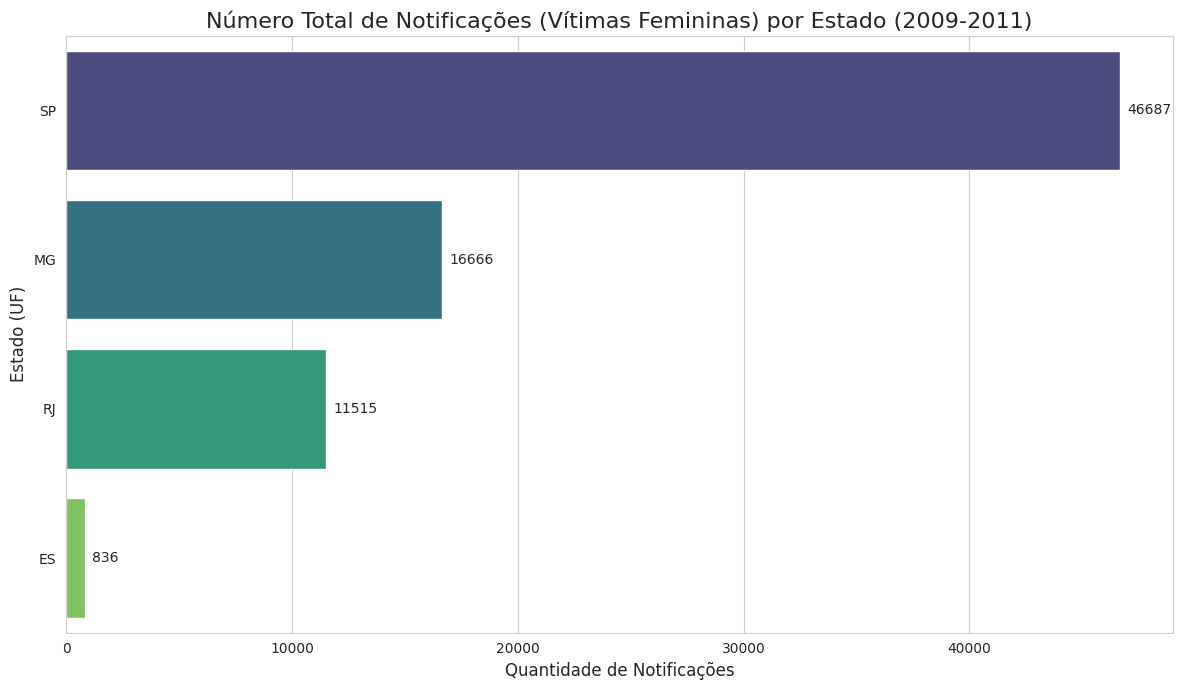

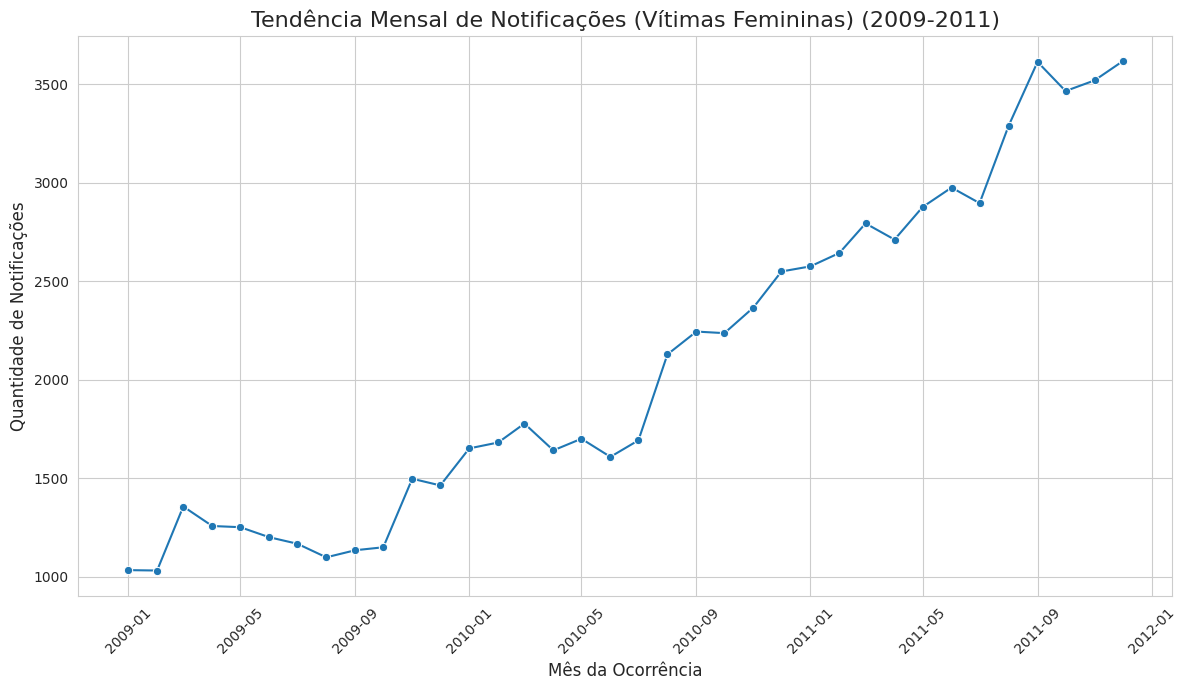


Generating victim demographic graphs...


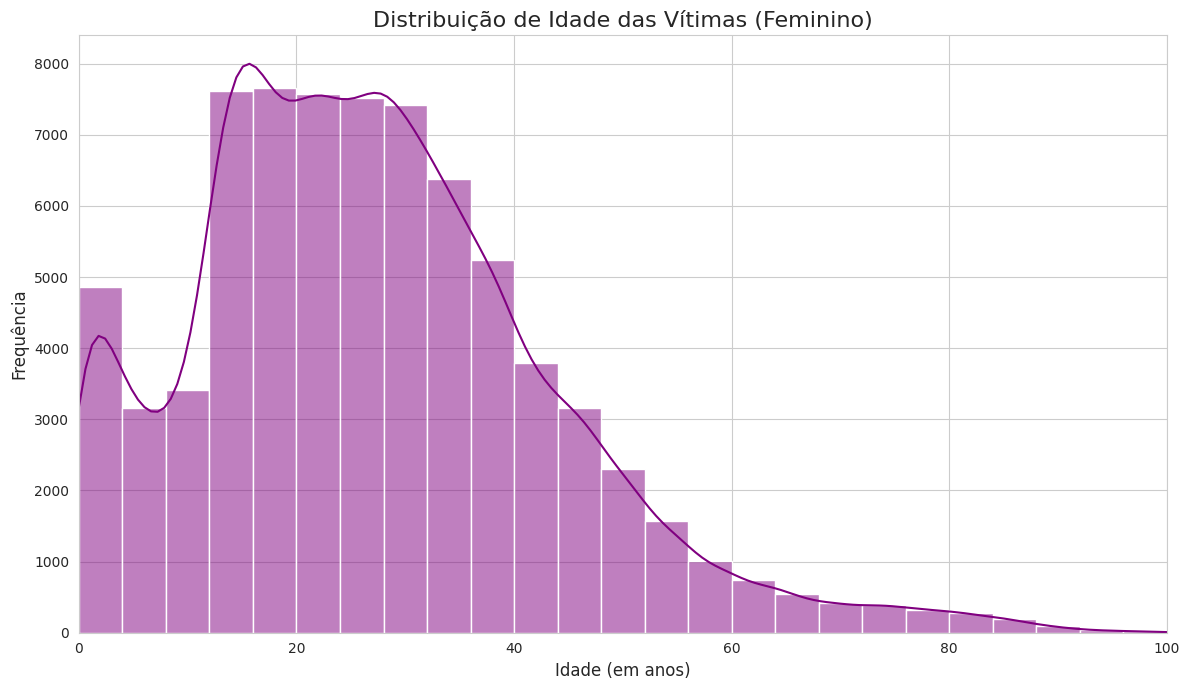


Gender distribution (Note: All records are now for female victims)
sexo_paciente
FEMININO    75554
IGNORADO      150
Name: count, dtype: int64


/tmp/ipython-input-66-3518730182.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y='raca_cor', data=df_master, order=df_master['raca_cor'].value_counts().index, palette='magma')


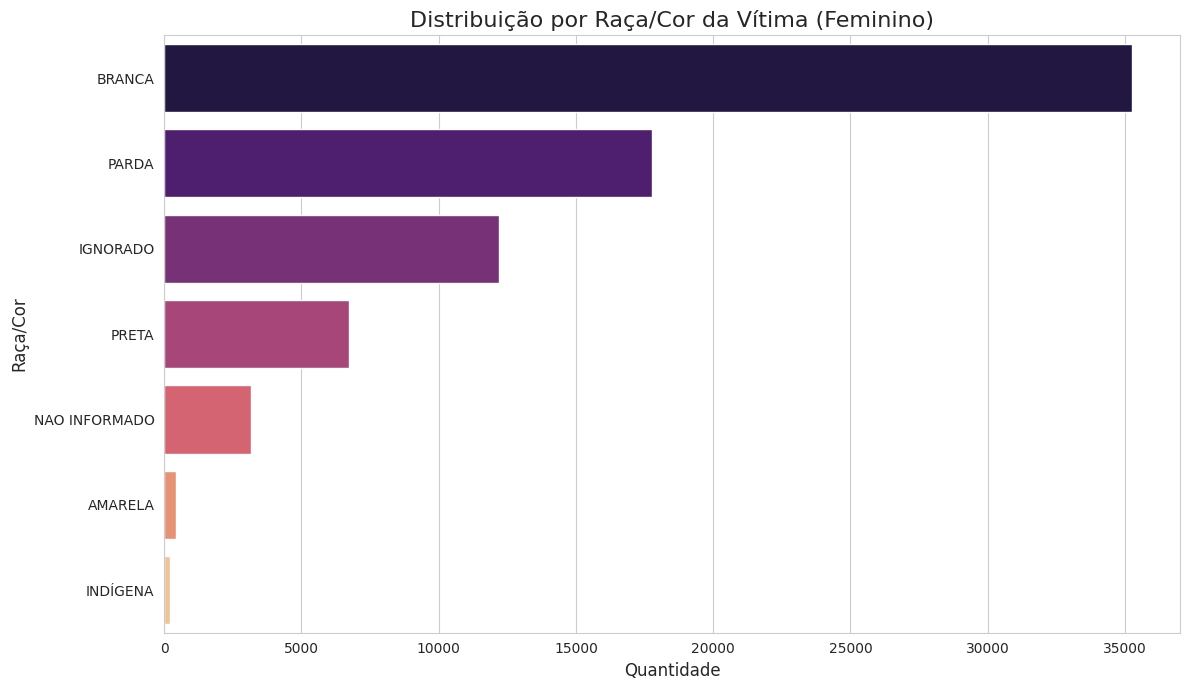


Generating graphs on the nature of the violence...


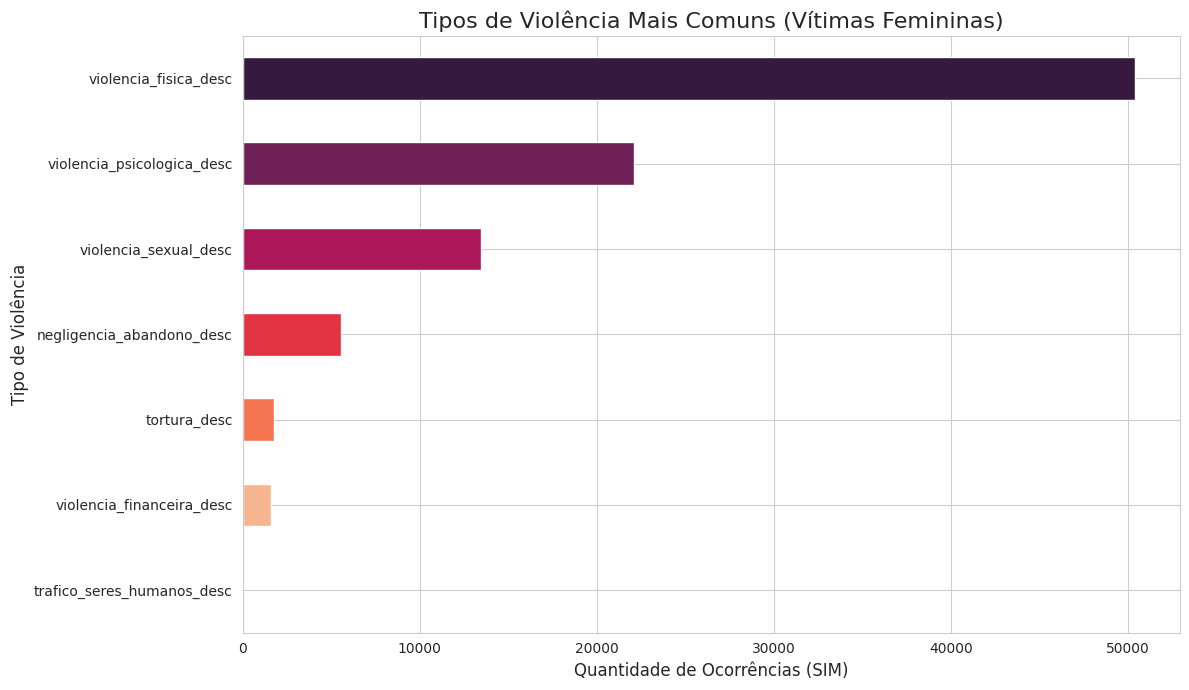

/tmp/ipython-input-66-3518730182.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y='local_ocorrencia', data=df_master, order=df_master['local_ocorrencia'].value_counts().index, palette='cubehelix')


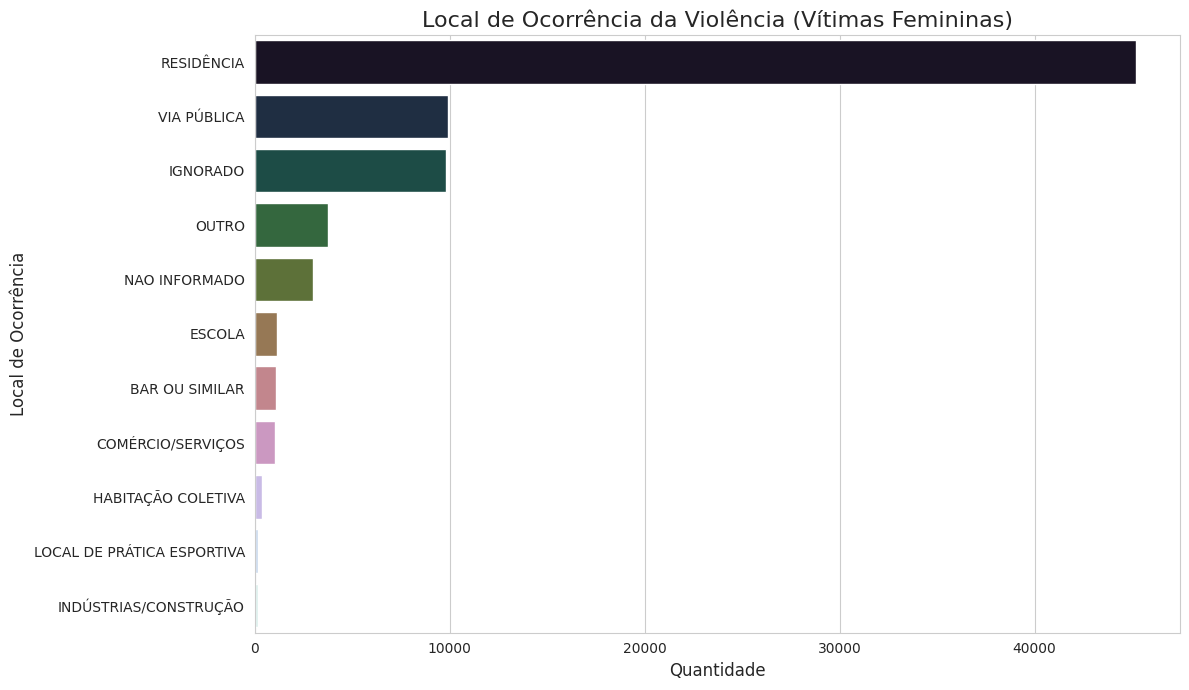

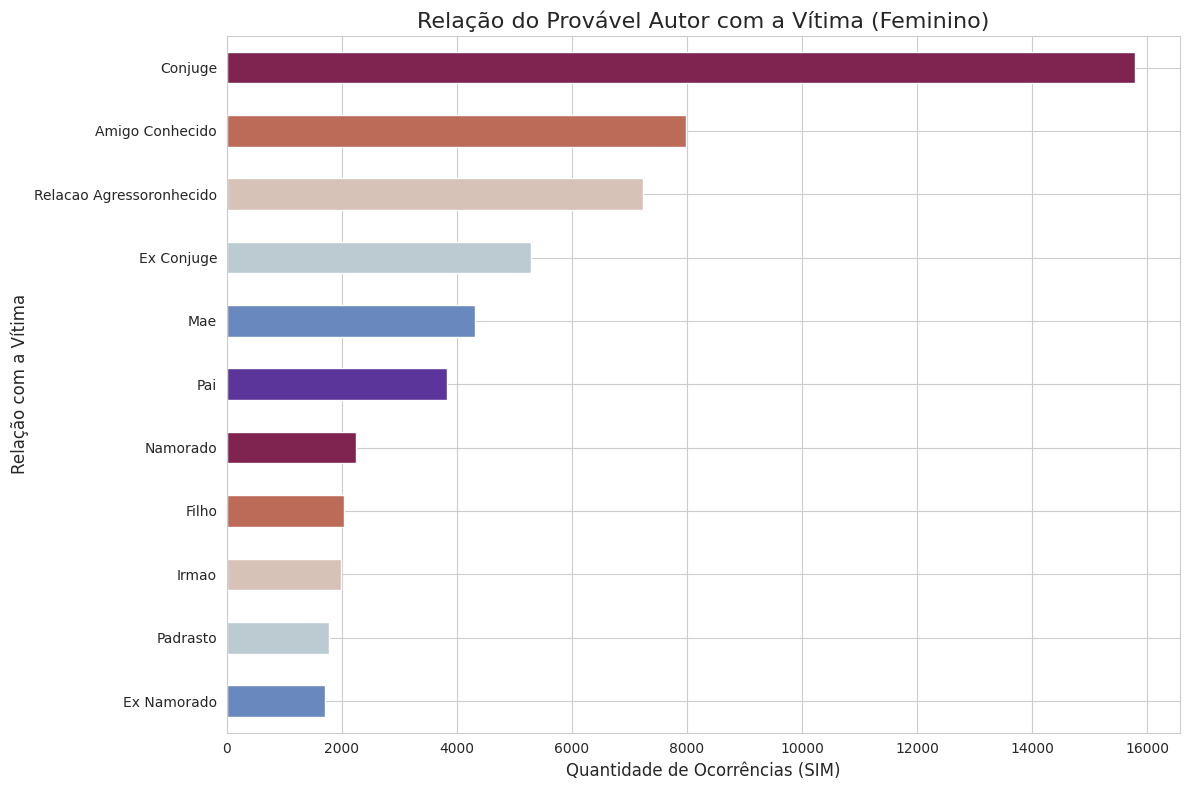

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

if not df_master.empty:
    # Set plot style for better aesthetics
    sns.set_style("whitegrid")
    plt.rcParams['figure.figsize'] = (12, 7)
    plt.rcParams['figure.autolayout'] = True

    """##  1. High-Level Overview"""

    print("Generating high-level overview graphs...")

    # a. Bar chart of cases per state
    plt.figure()
    ax = sns.countplot(y='uf', data=df_master, order=df_master['uf'].value_counts().index, palette='viridis')
    ax.set_title('Número Total de Notificações (Vítimas Femininas) por Estado (2009-2011)', fontsize=16)
    ax.set_xlabel('Quantidade de Notificações', fontsize=12)
    ax.set_ylabel('Estado (UF)', fontsize=12)
    # Add count labels to the bars
    for p in ax.patches:
        ax.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2.),
                    ha='left', va='center', xytext=(5, 0), textcoords='offset points', fontsize=10)
    plt.show()

    # b. Line chart of cases over time (by month)
    df_master['mes_ocorrencia'] = df_master['data_ocorrencia'].dt.to_period('M')
    monthly_cases = df_master.groupby('mes_ocorrencia').size().reset_index(name='contagem')
    monthly_cases['mes_ocorrencia'] = monthly_cases['mes_ocorrencia'].dt.to_timestamp()

    plt.figure()
    ax = sns.lineplot(x='mes_ocorrencia', y='contagem', data=monthly_cases, marker='o')
    ax.set_title('Tendência Mensal de Notificações (Vítimas Femininas) (2009-2011)', fontsize=16)
    ax.set_xlabel('Mês da Ocorrência', fontsize=12)
    ax.set_ylabel('Quantidade de Notificações', fontsize=12)
    plt.xticks(rotation=45)
    plt.show()

    """## 2. Victim Demographics"""

    print("\nGenerating victim demographic graphs...")

    # a. Histogram of victim age
    plt.figure()
    ax = sns.histplot(df_master['idade_anos'], bins=30, kde=True, color='purple')
    ax.set_title('Distribuição de Idade das Vítimas (Feminino)', fontsize=16)
    ax.set_xlabel('Idade (em anos)', fontsize=12)
    ax.set_ylabel('Frequência', fontsize=12)
    ax.set_xlim(0, 100) # Set a reasonable age limit
    plt.show()

    # b. Bar chart of victim gender (This plot is no longer very useful as we filtered for females)
    print("\nGender distribution (Note: All records are now for female victims)")
    print(df_master['sexo_paciente'].value_counts())


    # c. Bar chart of victim race/color
    plt.figure()
    ax = sns.countplot(y='raca_cor', data=df_master, order=df_master['raca_cor'].value_counts().index, palette='magma')
    ax.set_title('Distribuição por Raça/Cor da Vítima (Feminino)', fontsize=16)
    ax.set_xlabel('Quantidade', fontsize=12)
    ax.set_ylabel('Raça/Cor', fontsize=12)
    plt.show()

    """## 3. Nature of the Violence"""

    print("\nGenerating graphs on the nature of the violence...")

    # a. Bar chart of most common types of violence
    violencia_cols_desc = [
        'violencia_fisica_desc', 'violencia_psicologica_desc', 'violencia_sexual_desc',
        'tortura_desc', 'violencia_financeira_desc', 'negligencia_abandono_desc', 'trafico_seres_humanos_desc'
    ]
    # We need to check if the columns exist before processing
    existing_violencia_cols = [col for col in violencia_cols_desc if col in df_master.columns]
    violencia_counts = df_master[existing_violencia_cols].apply(lambda x: (x == 'SIM').sum()).sort_values(ascending=False)


    plt.figure()
    ax = violencia_counts.plot(kind='barh', color=sns.color_palette('rocket'))
    ax.set_title('Tipos de Violência Mais Comuns (Vítimas Femininas)', fontsize=16)
    ax.set_xlabel('Quantidade de Ocorrências (SIM)', fontsize=12)
    ax.set_ylabel('Tipo de Violência', fontsize=12)
    # Invert y-axis for better readability
    ax.invert_yaxis()
    plt.show()

    # b. Bar chart for location of occurrence
    plt.figure()
    ax = sns.countplot(y='local_ocorrencia', data=df_master, order=df_master['local_ocorrencia'].value_counts().index, palette='cubehelix')
    ax.set_title('Local de Ocorrência da Violência (Vítimas Femininas)', fontsize=16)
    ax.set_xlabel('Quantidade', fontsize=12)
    ax.set_ylabel('Local de Ocorrência', fontsize=12)
    plt.show()

    # c. Bar chart for the victim's relationship with the aggressor
    agressor_cols_desc = [
        'relacao_agressor_conjuge_desc', 'relacao_agressor_ex_conjuge_desc',
        'relacao_agressor_namorado_desc', 'relacao_agressor_ex_namorado_desc',
        'relacao_agressor_pai_desc', 'relacao_agressor_mae_desc', 'relacao_agressor_padrasto_desc',
        'relacao_agressor_irmao_desc', 'relacao_agressor_filho_desc',
        'relacao_agressor_amigo_conhecido_desc', 'relacao_agressor_desconhecido_desc'
    ]

    # Clean up column names for the plot labels
    agressor_labels = [col.replace('_desc', '').replace('relacao_agressor_', '').replace('_', ' ').title() for col in agressor_cols_desc]
    # We need to check if the columns exist before processing
    existing_agressor_cols = [col for col in agressor_cols_desc if col in df_master.columns]
    agressor_counts = df_master[existing_agressor_cols].apply(lambda x: (x == 'SIM').sum())
    agressor_counts.index = agressor_labels
    agressor_counts = agressor_counts.sort_values(ascending=False)

    plt.figure(figsize=(12, 8))
    ax = agressor_counts.plot(kind='barh', color=sns.color_palette('twilight_shifted_r'))
    ax.set_title('Relação do Provável Autor com a Vítima (Feminino)', fontsize=16)
    ax.set_xlabel('Quantidade de Ocorrências (SIM)', fontsize=12)
    ax.set_ylabel('Relação com a Vítima', fontsize=12)
    ax.invert_yaxis()
    plt.show()
else:
    print("Dataframe is empty, skipping analysis.")